# All in One for the Exam

Time flies, and the exam is coming. To help you to review the course, we have prepared this notebook, which contains all the materials we have covered in the course. We hope this notebook can help you to review the course and prepare for the exam.

This exam review document __does not cover the materials you studied from the lecture, whereas 
it only covers the materials from tutorial and lab__. You should also review the lecture materials.

Here is the list of topics we have covered and will be covered in the exam:

1. introduction to data.table (all about structure of data and type of data)
2. using data.table to manipulate data (most of this part __will not be tested__ in the exam)
3. basic data visualization
4. introduction to linear regression
5. introduction to logistic regression (maybe a small question)

## 1. Introduction to data.table

Broadly speaking, there are two kinds of data: __structured data__ and __unstructured data__. 
Structured data is data that has a structure, such as a table, whereas unstructured data is data that does not have a structure, such as a text file. In this course, we focus on structured data. This means all the data we will use look like tables, such 
as the following one:

![data.table-example](../drawio/R-data-table-illustration.png)

> Small story (will not be tested in the exam): I had a talk with a person who is the principal data scientist and  working for the government. He told me that the government is implementing a strategy called "AI in 2030". The goal of this strategy is to make the government to be more data-driven and AI-driven. He told me that every year they have to pay a lot of money to consultancies such as Boston Consulting Group (BCG) to do data analysis for them. He said that the government now is planning to combine data scientist and ChatGPT to do the data analysis. They are hoping that they could reduce 40% of the cost by doing so. The idea is that they will only hire BCG for those very complex data analysis tasks. For those simple tasks, they will use AI to do the data analysis. The main tool that BCG uses is Excel, SQL and Tableau. They are all table-based tools. This means having a good understanding of table-based data analysis is very important. This is why we start from data.table.

The basic syntax of data.table is summarized in the following illustration. __You will
not be tested on the syntax of data.table in the exam__. However, you will be tested on the
underlying concepts of data.table, such as the type of variables (integer, character, factor, etc.).
In the future if you will be working as a data scientist, you can use data.table to do big
data analysis. You will need to know the syntax of data.table for practical use not for the exam.

![data.table-syntax](../drawio/R-data-table-illustration2.png)

## 2. Using data.table to manipulate data

Now, we will use data.table to do some data analysis. We will use the `Community Innovation Survey` (CIS)
to do the analysis. The CIS is a survey that is conducted by the European Union (EU) to collect data
about innovation activities of firms. The survey we will use is the 2021 CIS from Germany.

In [ ]:
# install packages
install.packages("stargazer")
# install ISLR if you don't have it
# install.packages("ISLR")
install.packages("corrplot")

In [1]:
# library for data analysis
library(data.table)
library(magrittr)
library(ggplot2)
library(knitr)
library(stargazer)
library(MASS)
library(ISLR)
library(corrplot)


Please cite as: 


 Hlavac, Marek (2022). stargazer: Well-Formatted Regression and Summary Statistics Tables.

 R package version 5.2.3. https://CRAN.R-project.org/package=stargazer 


corrplot 0.92 loaded



In [3]:
# read data
# original url: https://raw.githubusercontent.com/oceanumeric/data-science-go-small/main/data/innovation_survey/extmidp21.csv
cis <- fread("https://shorturl.at/wBESZ")

In [ ]:
# check dimension, which shows 5083 rows and 284 columns
dim(cis)

In [ ]:
# take a look at the first 5 rows
head(cis)

From the above table, we can see that we have:

- integer variables: `id`
- character variables: `branche`, `ost`, etc.
- numeric variables (dbl): `bges`, `bges18`, etc.

In [ ]:
# now we want to select all variables that are type of dbl (double - numeric like 3.1415926)
# .SD means subset of data in j (select all columns)
# .SDcols means subset columns that are double which is by = is.double
# all things we will do in excel, SQL, or data.table can be summarized as
# I want to do things on rows (i) or columns (j) by some conditions (by)
# here we want to select all columns that are double
cis %>%
    # using [i, j, by] grammar
    .[, .SD, .SDcols = is.double] %>% head()

Before we continue, let's get to know the meaning of some variables (we have 41 numeric variables in total, so we will not cover all of them):

- bges: number of employees (average from 2018 to 2020)
- bges18: number of employees in 2018
- um18: sales in 2018
- lp19: labor productivity in 2019
- softws19: software application intensity in 2019
- wbp:  Weiterbildungskostenanteil (share of training costs)
- invs:  Investitionsintensitaet (investment intensity)

From the above table, you can see that we have many `NA` values. This is because the survey is a voluntary survey. This means that firms can choose whether they want to participate in the survey or not. If they choose to participate in the survey, they can choose whether they want to answer all the questions or not. This is why we have many `NA` values - missing values.

This is very common in real-world data. To deal with this issue, we normally do the following (will not be tested in the exam):

- check the number of missing values
- check the pattern of missing values
- decide whether we want to drop the missing values or impute the missing values

In [ ]:
# check the number of missing values in each column
cis %>%
    .[, .SD, .SDcols = is.double] %>%
    # check the number of missing values in each column
    sapply(function(x) sum(is.na(x))) %>%
    # sort the number of missing values in each column
    sort(decreasing = TRUE) %>%
    # convert to data.table and keep rownames as a column
    as.data.table(keep.rownames = TRUE) %>%
    head(10)

#### Missing Values

- wmenup: Umsatzanteil der Weltmarktneuheiten in 2020 (share of world market novelties in 2020)
- lap2022:  Entw. Innovationsaufw. 2022 in % (Development of innovation expenditure 2022 in %)
- fueoefms:  Intensitaet öffentliche FuE-Förderung (Intensity of public R&D funding)

We do not know exactly why we have so many missing values. However, we can guess that the reason is that the firms do not want to disclose the information or do not have information. For instance, because of the pandemic in 2020,
many firms might not have the information about the share of world market novelties in 2020. 
This could be the reason why we have so many missing values for `wmenup`.

We have shown that the sample size is 5083, if one variable has more than 50% missing values, we will drop this variable.
This is because we can do nothing about this variable. If we impute the missing values, we will introduce bias to the data.

In [ ]:
dim(cis)

In [ ]:
# get variable names that have more than 50% missing values
cis %>%
    .[, .SD, .SDcols = is.double] %>%
    # check the number of missing values in each column
    sapply(function(x) sum(is.na(x))) %>%
    # sort the number of missing values in each column
    sort(decreasing = TRUE) %>%
    # convert to data.table and keep rownames as a column
    as.data.table(keep.rownames = TRUE) %>%
    head()
# notice that the variable name of second column is a `.`
# we will rename it as `num_missing` (number of missing values)

In [ ]:
cis %>%
    .[, .SD, .SDcols = is.double] %>%
    # check the number of missing values in each column
    sapply(function(x) sum(is.na(x))) %>%
    # sort the number of missing values in each column
    sort(decreasing = TRUE) %>%
    # convert to data.table and keep rownames as a column
    as.data.table(keep.rownames = TRUE) %>%
    # rename the second column
    setnames(., old = ".", new = "num_missing") %>%
    head()

In [ ]:
cis %>%
    .[, .SD, .SDcols = is.double] %>%
    # check the number of missing values in each column
    sapply(function(x) sum(is.na(x))) %>%
    # sort the number of missing values in each column
    sort(decreasing = TRUE) %>%
    # convert to data.table and keep rownames as a column
    as.data.table(keep.rownames = TRUE) %>%
    # rename the second column
    setnames(., old = ".", new = "num_missing") %>%
    # add missing percentage column
    # nrow is the number of rows in the dataset nrow(cis) = dim(cis)[1] = 5083
    .[, missing_rate := num_missing / nrow(cis)] %>%
    head()

> Normally, I will use `%>%` to do everything in one block. However, here I am trying to show you the steps one by one. So, you can see the process clearly.

In [ ]:
cis %>%
    .[, .SD, .SDcols = is.double] %>%
    # check the number of missing values in each column
    sapply(function(x) sum(is.na(x))) %>%
    # sort the number of missing values in each column
    sort(decreasing = TRUE) %>%
    # convert to data.table and keep rownames as a column
    as.data.table(keep.rownames = TRUE) %>%
    # rename the second column
    setnames(., old = ".", new = "num_missing") %>%
    # add missing percentage column
    # nrow is the number of rows in the dataset nrow(cis) = dim(cis)[1] = 5083
    .[, missing_rate := num_missing / nrow(cis)] %>%
    # filter variables that have missing rate > 0.5
    # we are using [i, j, by] grammar again on rows now
    .[missing_rate >= 0.5]

# as you can see we have 18 variables that have missing rate > 0.5
# we will remove them from the dataset

In [ ]:
cis %>%
    .[, .SD, .SDcols = is.double] %>%
    # check the number of missing values in each column
    sapply(function(x) sum(is.na(x))) %>%
    # sort the number of missing values in each column
    sort(decreasing = TRUE) %>%
    # convert to data.table and keep rownames as a column
    as.data.table(keep.rownames = TRUE) %>%
    # rename the second column
    setnames(., old = ".", new = "num_missing") %>%
    # add missing percentage column
    # nrow is the number of rows in the dataset nrow(cis) = dim(cis)[1] = 5083
    .[, missing_rate := num_missing / nrow(cis)] %>%
    # filter variables that have missing rate > 0.5
    # we are using [i, j, by] grammar again on rows now
    .[missing_rate >= 0.5] %>%
    # select the first column as they are the variable names
    # [i, j, by]
    .[, rn]

In [ ]:
cis %>%
    .[, .SD, .SDcols = is.double] %>%
    # check the number of missing values in each column
    sapply(function(x) sum(is.na(x))) %>%
    # sort the number of missing values in each column
    sort(decreasing = TRUE) %>%
    # convert to data.table and keep rownames as a column
    as.data.table(keep.rownames = TRUE) %>%
    # rename the second column
    setnames(., old = ".", new = "num_missing") %>%
    # add missing percentage column
    # nrow is the number of rows in the dataset nrow(cis) = dim(cis)[1] = 5083
    .[, missing_rate := num_missing / nrow(cis)] %>%
    # filter variables that have missing rate > 0.5
    # we are using [i, j, by] grammar again on rows now
    .[missing_rate >= 0.5] %>%
    # select the first column as they are the variable names
    # [i, j, by]
    # save the variable names to a variable called vars_to_remove
    .[, rn] -> vars_to_remove

In [ ]:
# in jupyter notebook we can use vars_to_remove to see the variable names
vars_to_remove

In [ ]:
# or you can print out the variable names
print(vars_to_remove)

In [ ]:
# now we will remove the variables from the dataset
cis %>%
    # select variables that are numeric (double)
    .[, .SD, .SDcols = is.double] %>%
    # remove variables that are in vars_to_remove
    # with means we are usig column names instead of column indices
    # at by position
    .[, !vars_to_remove, with = FALSE] %>%
    head()

In [ ]:
# compare with the original dataset
cis %>%
    .[, .SD, .SDcols = is.double] %>%
    dim()  # 41 columns (variables)

In [ ]:
cis %>%
    # select variables that are numeric (double)
    .[, .SD, .SDcols = is.double] %>%
    # remove variables that are in vars_to_remove
    # with means we are using column names instead of column indices
    # with means we are using column names instead of column indices
    .[, !vars_to_remove, with = FALSE] %>%
    dim()  # 23 columns (variables)

In [ ]:
# with all numeric variables and not many missing values
# we can check the correlation between variables
cis %>%
    # select variables that are numeric (double)
    .[, .SD, .SDcols = is.double] %>%
    # remove variables that are in vars_to_remove
    # with means we are using column names instead of column indices
    # with means we are using column names instead of column indices
    .[, !vars_to_remove, with = FALSE] %>%
    # calculate the correlation between variables without missing values
    cor(use = "pairwise.complete.obs") %>%
    # plot the correlation matrix
    corrplot(method = "color")

You might see the correlation plot like the above one in the exam. I will tell you
the meaning of variables:

- bges: number of employees (average from 2018 to 2020)
- bges18: number of employees in 2018
- um18: sales in 2018
- lp19: labor productivity in 2019
- softws19: software application intensity in 2019
- wbp:  Weiterbildungskostenanteil (share of training costs)
- invs:  Investitionsintensitaet (investment intensity)
- exs:  Exportintensitaet insgesamt (total export intensity)
- markets:  Marketingaufwendungen Intensitaet (marketing expenditure intensity)
- designs:  Designaufwendungen Intensitaet (design expenditure intensity)

For instance, I might ask you:

- in the graph, we see the correlated cluster of `markets`, `designs`, and `softws19`. What does this mean?
- in the graph, we see that there is correlation between `exs`, `bges` and `bges18`, what kind of hypothesis can we make based on this correlation?

In [ ]:
# we can also use circlize to plot the correlation matrix
cis %>%
    # select variables that are numeric (double)
    .[, .SD, .SDcols = is.double] %>%
    # remove variables that are in vars_to_remove
    # with means we are using column names instead of column indices
    # with means we are using column names instead of column indices
    .[, !vars_to_remove, with = FALSE] %>%
    # calculate the correlation between variables without missing values
    cor(use = "pairwise.complete.obs") %>%
    # plot the correlation matrix with circlize with half matrix
    corrplot(method = "circle", type = "upper")

The correlation plot could give us a big picture on what's going on. For instance,

- factors are grouped together based on their correlation
- the bigger the circle, the higher the correlation
- the color of the circle indicates the sign of the correlation (blue: positive, red: negative)

Based on the correlation plot, you can combine your domain knowledge to make hypothesis.

However, __This kind of correlation plot only gives a global picture. It does not tell us the whole story__. For instance, we are not zooming into the industry level analysis. __It is 
very likely that the correlationb between say `markets` and `designs` is different for different industries__. This is why we need to do industry level analysis.

### CIS with Industry Level Analysis

Now, we will do industry level analysis. We will use the `branche` variable to do the
industry level analysis.

- `branche`:  Einteil. in 21 Wirtschaftszweige (classification into 21 economic sectors)

In [ ]:
# get to know branche
cis %>%
    # select branche with [i, j, by]
    # .(branchen) is the same as c("branchen")
    .[, .(branche)] %>%
    head()

In [ ]:
# we can check how many unique values in branche
cis %>%
    .[, .(branche)] %>%
    # unique() returns the unique values
    unique()  # 21 unique values (industries)

In [ ]:
# branche is character
# we can calculate the frequency of each branche
cis %>%
    .[, .(branche)] %>%
    # calculate the frequency of each branche
    # [i, j, by] by = branche means we are grouping by branche
    # .N is calculating the number of rows in each group
    .[, .N, by = branche]

In [ ]:
cis %>%
    .[, .(branche)] %>%
    # calculate the frequency of each branche
    # [i, j, by] by = branche means we are grouping by branche
    # .N is calculating the number of rows in each group
    .[, .N, by = branche] %>%
    # sort the frequency in descending order
    # order(-N) means we are sorting N in descending order
    # we put it into i position because we are sorting rows
    .[order(-N)]

The industry distribution shows the 'big picutre' of German economy. We can see that the most important industry is `Transport/Post` , `Wasser/Entsorgung/Recycling`, and `Metallerzeugung/-bearbeitung`. __Be careful that we might have selection bias here__. This is because the survey is a voluntary survey. This means that firms can choose whether they want to participate in the survey or not. So, the industry distribution might not be representative.

When we see those industries, we are interested in:

- what are the characteristics of those industries?
- which industries are similar to each other?
- which industries are different from each other?
- what are the characteristics of the firms in those industries?

Since we have many industries, to find out which industries are similar to each other 
is not easy by analyzing the dataset. __We have to reply on our domain knowledge__. Here,
we expect that `Transport/Post` and `Metallerzeugung/-bearbeitung` are similar to each other.

With our domain knowledge, we will focus on three groups of industries:

- indus1: `Transport/Post`, `Metallerzeugung/-bearbeitung`, and `Maschinenbau`
- indus2: `Unternehmensdienste`,  `Unternehmensberatung/Werbung`, and `Finanzdienstleistungen`
- indus3: `Elektroindustrie`, and `Mediendienstleistungen`, and `EDV/Telekommunikation`

We will now select the firms in those industries and group them together.

In [ ]:
# create a variables that will include industries we will focus on
indus1 <- c(
    "Transport/Post", "Metallerzeugung/-bearbeitung", "Maschinenbau"
)
indus2 <- c(
    "Unternehmensdienste", "Unternehmensberatung/Werbung", "Finanzdienstleistungen"
)
indus3 <- c(
    "Elektroindustrie", "Mediendienstleistungen", "EDV/Telekommunikation"
)

In [ ]:
# now select all the rows that have branche in indus1, indus2, indus3
cis %>%
    # [i, j, by] at i postion
    # filter out branche are in indus1, indus2, indus3
    # | means or in R
    # %in% means is in
    .[branche %in% indus1 | branche %in% indus2 | branche %in% indus3] %>%
    dim()

In [ ]:
cis %>%
    # [i, j, by] at i postion
    # filter out branche are in indus1, indus2, indus3
    # | means or in R
    # %in% means is in
    .[branche %in% indus1 | branche %in% indus2 | branche %in% indus3] %>%
    # verify the result
    .[, .(branche)] %>%
    unique()

In [ ]:
cis %>%
    # [i, j, by] at i postion
    # filter out branche are in indus1, indus2, indus3
    # | means or in R
    # %in% means is in
    .[branche %in% indus1 | branche %in% indus2 | branche %in% indus3] %>%
    # verify the result
    .[, .(branche)] %>%
    # calculate the frequency of each branche
    .[, .N, by = branche]

In [ ]:
# now we group them 
cis %>%
    # [i, j, by] at i postion
    # filter out branche are in indus1, indus2, indus3
    # | means or in R
    # %in% means is in
    .[branche %in% indus1 | branche %in% indus2 | branche %in% indus3] %>%
    # add a new variable called industry
    # fill indus1, indus2, indus3 based on branche
    .[, industry := ifelse(
        branche %in% indus1, "indus1",
        ifelse(branche %in% indus2, "indus2", "indus3")
    )] %>%
    head()  # variable industry is added to the dataset at the last column

In [ ]:
cis %>%
    # [i, j, by] at i postion
    # filter out branche are in indus1, indus2, indus3
    # | means or in R
    # %in% means is in
    .[branche %in% indus1 | branche %in% indus2 | branche %in% indus3] %>%
    # add a new variable called industry
    # fill indus1, indus2, indus3 based on branche
    .[, industry := ifelse(
        branche %in% indus1, "indus1",
        ifelse(branche %in% indus2, "indus2", "indus3")
    )] %>%
    # verify the result by selecting branche and industry
    .[, .(branche, industry)] %>%
    head()

After classifying the industry, we can compare the correlation between different
industries. We want to see whether the relationship between for instance `export` and 
`labor productivity` is different for different industries.

In [ ]:
# we will create a vector that will include all the variables we will use

In [ ]:
# plot correlation matrix for indus1 - machineary industry or related (transport/post, metal, machine)
cis %>%
    # filter out branche are in indus1, indus2, indus3
    .[branche %in% indus1 | branche %in% indus2 | branche %in% indus3] %>%
    # add a new variable called industry
    .[, industry := ifelse(
        branche %in% indus1, "indus1",
        ifelse(branche %in% indus2, "indus2", "indus3")
    )] %>%
    # filter out the indust1
    .[industry == "indus1"] %>%
    # select the variables are double
    .[, .SD, .SDcols = is.double] %>%
    # remove variables that are in vars_to_remove
    .[, !vars_to_remove, with = FALSE] %>%
    # calculate the correlation between variables without missing values
    cor(use = "pairwise.complete.obs") %>%
    # plot the correlation matrix with circlize with half matrix
    corrplot(method = "circle", type = "upper")

In [ ]:
# plot correlation matrix for indus2 - business services industry or related (business services, consulting, finance)
cis %>%
    # filter out branche are in indus1, indus2, indus3
    .[branche %in% indus1 | branche %in% indus2 | branche %in% indus3] %>%
    # add a new variable called industry
    .[, industry := ifelse(
        branche %in% indus1, "indus1",
        ifelse(branche %in% indus2, "indus2", "indus3")
    )] %>%
    # filter out the indust1
    .[industry == "indus2"] %>%
    # select the variables are double
    .[, .SD, .SDcols = is.double] %>%
    # remove variables that are in vars_to_remove
    .[, !vars_to_remove, with = FALSE] %>%
    # calculate the correlation between variables without missing values
    cor(use = "pairwise.complete.obs") %>%
    # plot the correlation matrix with circlize with half matrix
    corrplot(method = "circle", type = "upper")

In [ ]:
# plot correlation matrix for indus3 - IT industry or related (IT, telecom, media)
cis %>%
    # filter out branche are in indus1, indus2, indus3
    .[branche %in% indus1 | branche %in% indus2 | branche %in% indus3] %>%
    # add a new variable called industry
    .[, industry := ifelse(
        branche %in% indus1, "indus1",
        ifelse(branche %in% indus2, "indus2", "indus3")
    )] %>%
    # filter out the indust1
    .[industry == "indus3"] %>%
    # select the variables are double
    .[, .SD, .SDcols = is.double] %>%
    # remove variables that are in vars_to_remove
    .[, !vars_to_remove, with = FALSE] %>%
    # calculate the correlation between variables without missing values
    cor(use = "pairwise.complete.obs") %>%
    # plot the correlation matrix with circlize with half matrix
    corrplot(method = "circle", type = "upper")

Now, let's put them together and compare them. I will write a function to do this because 
we do not have to repeat the same code again and again (it will __not__ be tested in the exam).

In [ ]:
plot_correlation <- function(industry_name) {
    cis %>%
    # filter out branche are in indus1, indus2, indus3
    .[branche %in% indus1 | branche %in% indus2 | branche %in% indus3] %>%
    # add a new variable called industry
    .[, industry := ifelse(
        branche %in% indus1, "indus1",
        ifelse(branche %in% indus2, "indus2", "indus3")
    )] %>%
    # filter out the indust1
    .[industry == industry_name] %>%
    # select the variables are double
    .[, .SD, .SDcols = is.double] %>%
    # remove variables that are in vars_to_remove
    .[, !vars_to_remove, with = FALSE] %>%
    # calculate the correlation between variables without missing values
    cor(use = "pairwise.complete.obs") %>%
    # plot the correlation matrix with circlize with half matrix
    corrplot(method = "circle", type = "upper", title=industry_name, mar=c(0,0,2,0))
}

In [ ]:
# let's put them together and compare
cis %>%
    # filter out branche are in indus1, indus2, indus3
    .[branche %in% indus1 | branche %in% indus2 | branche %in% indus3] %>%
    # add a new variable called industry
    .[, industry := ifelse(
        branche %in% indus1, "indus1",
        ifelse(branche %in% indus2, "indus2", "indus3")
    )] %>%
    # select the variables are double
    .[, .SD, .SDcols = is.double] %>%
    # remove variables that are in vars_to_remove
    .[, !vars_to_remove, with = FALSE] %>%
    # calculate the correlation between variables without missing values
    cor(use = "pairwise.complete.obs") %>%
    # plot the correlation matrix with circlize with half matrix
    corrplot(method = "circle", type = "upper")  -> corr_overall

In [ ]:
# figure size
options(repr.plot.width = 10, repr.plot.height = 10)
plot_correlation("indus1")
plot_correlation("indus2")
plot_correlation("indus3")

Now, I put everything together and highlight some interesting phenomena.

![corr-plot](./indus_corr.png)

As you can see that the correlations between `export` and other variables are very different
cross different industries.

__Summary:__ for this part, you need to know that industry level analysis is very important.
For the coding part, you will not be tested in the exam. However, you need to know how to
do it in real life.

## 3. Basic data visualization

In this section, we will learn how to use basic data visualization tools to 
conduct exploratory data analysis by focusing on the following topics:

- univariate analysis (histogram, boxplot, density plot)
- bivariate analysis (scatter plot, line plot, bar plot)

Many concepts in this section will be tested in the exam. So, please pay attention to this section.

In [4]:
# we will use two datasets
# community innovation survey (cis), religion and innovation survey (ris)
# read data again
cis <- fread("https://shorturl.at/wBESZ")

In [ ]:
str(cis)

As you can see that we have many variables. It is not easy to understand the data by looking at the numbers. So, we need to visualize the data. We will select some variables of interest:

- ias:            Innovationsintensitaet
- iasx:             Stutzung Innovationsintensitaet
- iainvs:            Intensitaet investive Inno.
- iainvsx:          Stutzung Intens.inv.Inno
- iafues:           Intensitaet interne FuE
- iafuesx:         Stutzung Intens. interne FuE
- iavfues:         Intensitaet externe FuE
- iavfuesx:        Stutzung Intens. externe FuE
- iasos:           Intensitaet sonst. Innovationsaufw
- iasosx:          Stutzung sonst. Innovationsaufw

All those variables are related to innovation, which could be used as dependent variables.

In [ ]:
# get column index of ias
which(colnames(cis) == "ias")
# get column index of iasosx
which(colnames(cis) == "iasosx")

In [ ]:
# now we will select the columns we need from 107 to 116
cis %>%
    # in [i, j, by] you can use index too instead of column name
    .[, 107:116] %>%
    head()

In [ ]:
cis %>%
    .[, 107:116] %>%
    # check number of missing values
    sapply(function(x) sum(is.na(x))) %>%
    as.data.table(keep.rownames = TRUE)

As you can see that there are so many missing values. We will drop those missing values.
We will filter the data based on `ias`.

In [ ]:
# we will have 2056 firms, which is fine for our analysis
cis %>%
    .[!is.na(ias)] %>%
    dim()

In [ ]:
# we will focus on firms that have innovation intensity score
cis %>%
    # remove missing values for ias 
    .[!is.na(ias)] %>%
    # check the distribution of industry
    .[, .N, by = branche]

In [5]:
# create a variables that will include industries we will focus on
indus1 <- c(
    "Transport/Post", "Metallerzeugung/-bearbeitung", "Maschinenbau"
)
indus2 <- c(
    "Unternehmensdienste", "Unternehmensberatung/Werbung", "Finanzdienstleistungen"
)
indus3 <- c(
    "Elektroindustrie", "Mediendienstleistungen", "EDV/Telekommunikation"
)

In [ ]:
# we will filter out those three industries we will focus on
cis %>%
    # remove missing values for ias 
    .[!is.na(ias)] %>%
    # filter out branche are in indus1, indus2, indus3
    .[branche %in% indus1 | branche %in% indus2 | branche %in% indus3] %>%
    # add a new variable called industry
    .[, industry := ifelse(
        branche %in% indus1, "machineary",  # call indus1 as machineary
        ifelse(branche %in% indus2, "business", "IT")
    )] %>%
    head()

In [ ]:
# check distribution of industry
cis %>%
    # remove missing values for ias 
    .[!is.na(ias)] %>%
    # filter out branche are in indus1, indus2, indus3
    .[branche %in% indus1 | branche %in% indus2 | branche %in% indus3] %>%
    # add a new variable called industry
    .[, industry := ifelse(
        branche %in% indus1, "machineary",  # call indus1 as machineary
        ifelse(branche %in% indus2, "business", "IT")
    )]%>%
    .[, .N, by = industry]  # quite balanced

The above process is about cleaning and organizing the dataset, which is very important.
Now, we will create a new dataset based on our clearning process and call it `cis2`.

In [6]:
cis %>%
    # remove missing values for ias 
    .[!is.na(ias)] %>%
    # filter out branche are in indus1, indus2, indus3
    .[branche %in% indus1 | branche %in% indus2 | branche %in% indus3] %>%
    # add a new variable called industry
    .[, industry := ifelse(
        branche %in% indus1, "machineary",  # call indus1 as machineary
        ifelse(branche %in% indus2, "business", "IT")
    )] -> cis2

In [ ]:
dim(cis2)  # we only have 1042 firms 

In [ ]:
# let's check innovation intensity score (ias)
cis2 %>%
    .[, .(ias)] %>% head()

In [ ]:
# get summary statistics of ias
cis2 %>%
    .[, .(ias)] %>%
    summary()

The above summary is very important. It tells us that the first quartile is 0. This means that
25% of the firms do not have any innovation. The median is 0.001, which means that 50% of the firms have innovation intensity less than 0.001. The third quartile is 0.037, which means that 75% of the firms have innovation intensity less than 0.037. The maximum is 1.156, which means that the maximum innovation intensity is 1.156.

This is __very common__ in business world as most of the firms are not very innovative.

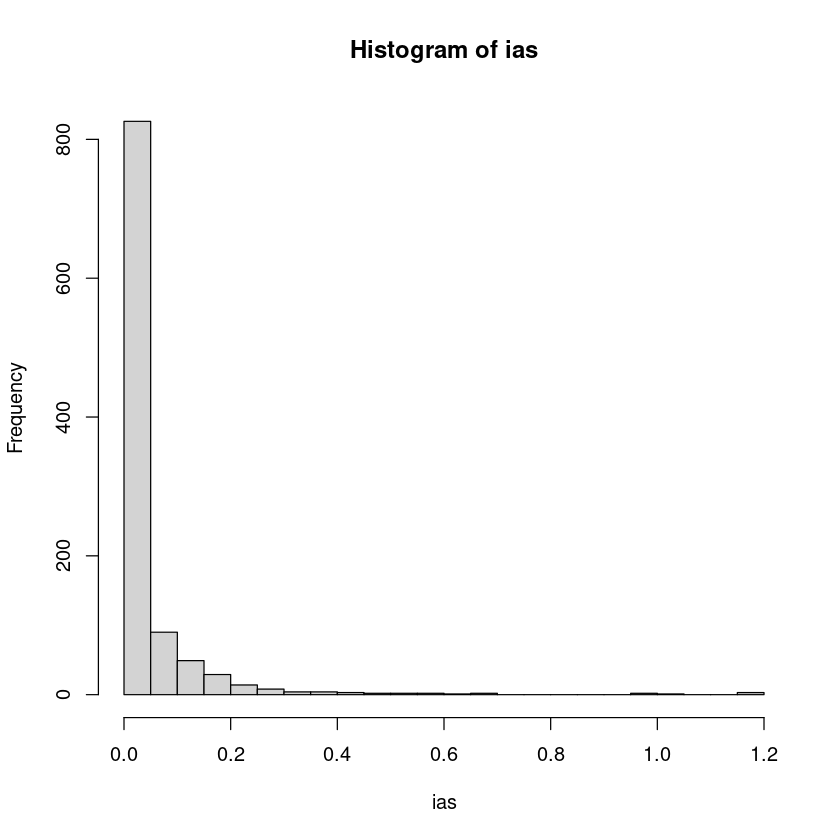

In [7]:
# plot the distribution of ias as it is a continuous variable
cis2 %>%
    .[, .(ias)] %>%
    with(hist(ias, breaks = 20))

In [8]:
# focus on firms that have ias > 0
cis2 %>%
    .[ias > 0] %>%
    dim()  # we have 536 firms

[1] 536 285

In [9]:
# check balance of industry
cis2 %>%
    .[ias > 0] %>%
    .[, .N, by = industry]  # not very balanced

industry,N
<chr>,<int>
IT,246
machineary,192
business,98


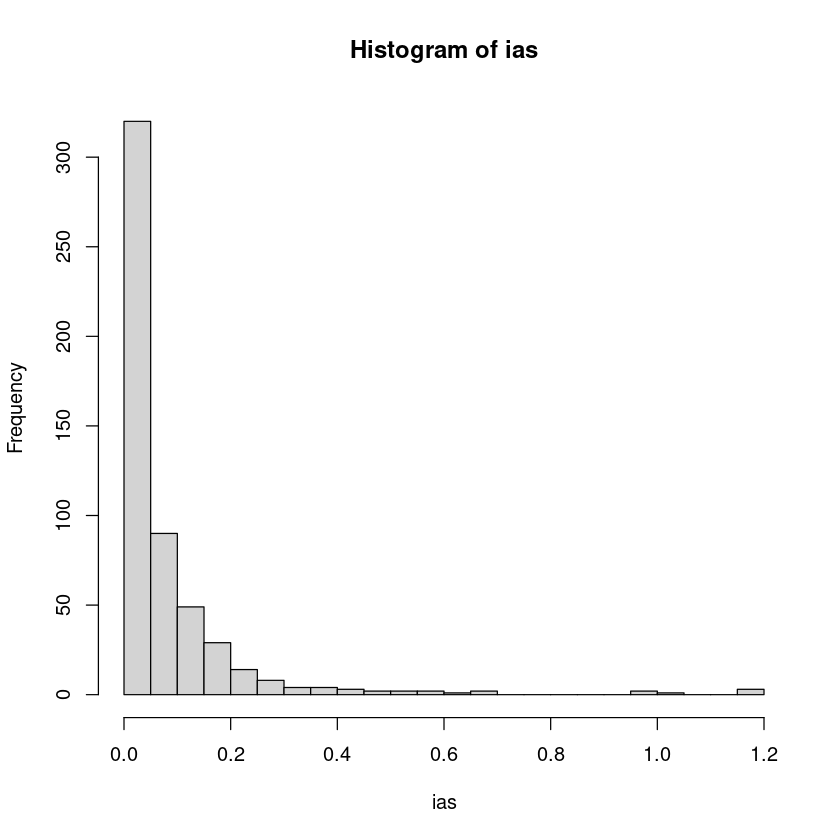

In [10]:
# focus on firms that have ias > 0
cis2 %>%
    .[ias > 0] %>%
    .[, .(ias)] %>%
    with(hist(ias, breaks = 20))

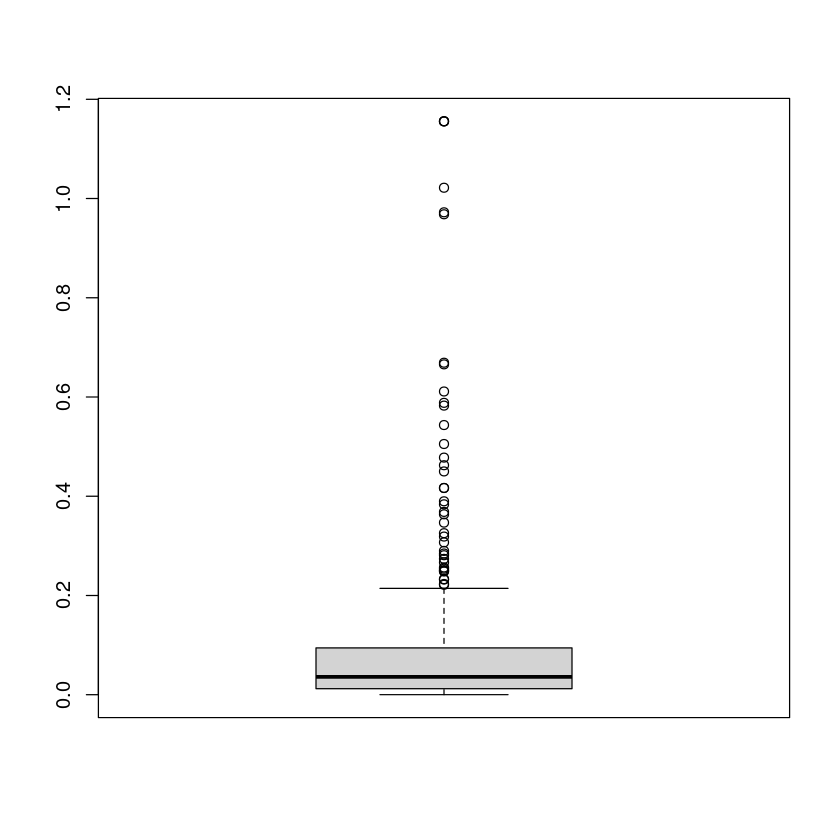

In [11]:
# boxplot
cis2 %>%
    .[ias > 0] %>%
    .[, .(ias)] %>%
    with(boxplot(ias))

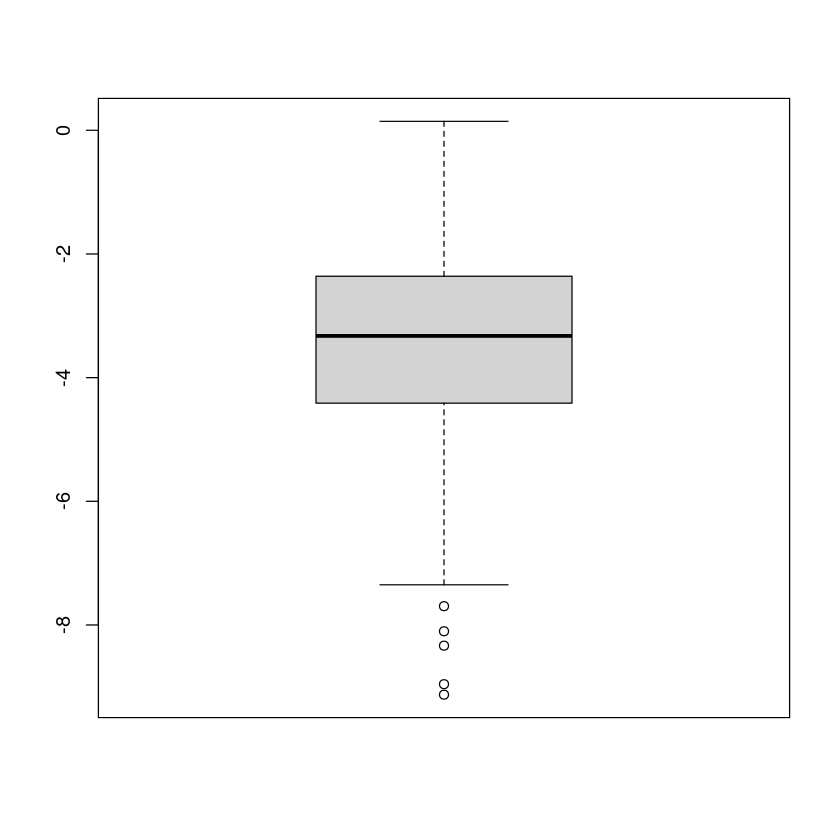

In [12]:
# as it can be seen, there are some outliers
# the distribution is right skewed
# we will use log transformation to make it more normal
cis2 %>%
    .[ias > 0] %>%
    .[, .(ias)] %>%
    # log transformation
    with(boxplot(log(ias)))


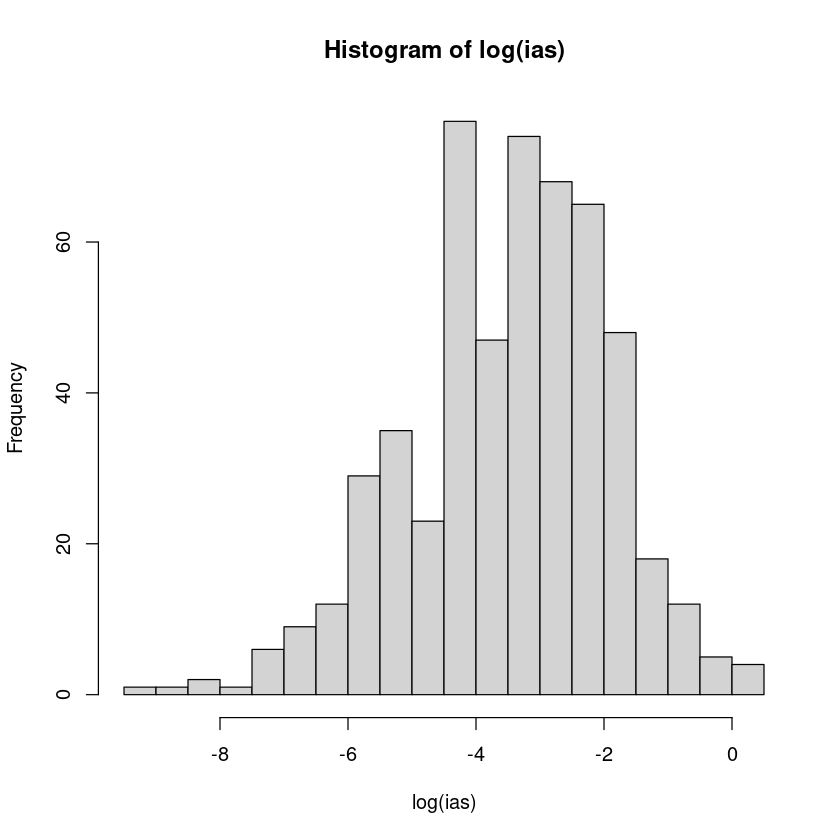

In [13]:
cis2 %>%
    .[ias > 0] %>%
    .[, .(ias)] %>%
    # log transformation and histogram
    with(hist(log(ias), breaks = 20))

### Normal Distribution

When we fit a linear regression model, if dependent variable is __continuous__, we prefer
the dependent variable to be normally distributed. So, we need to check whether the dependent variable is normally distributed. If not, we could use some transformation to make it normally distributed.
As we have covered in the lecture, there are __two main distributions__ you need to know:

- normal distribution (Gaussian distribution)
- binomial distribution

Possion distribution will not be tested in the exam.

![normal](../images/binomial-to-poisson2.png)

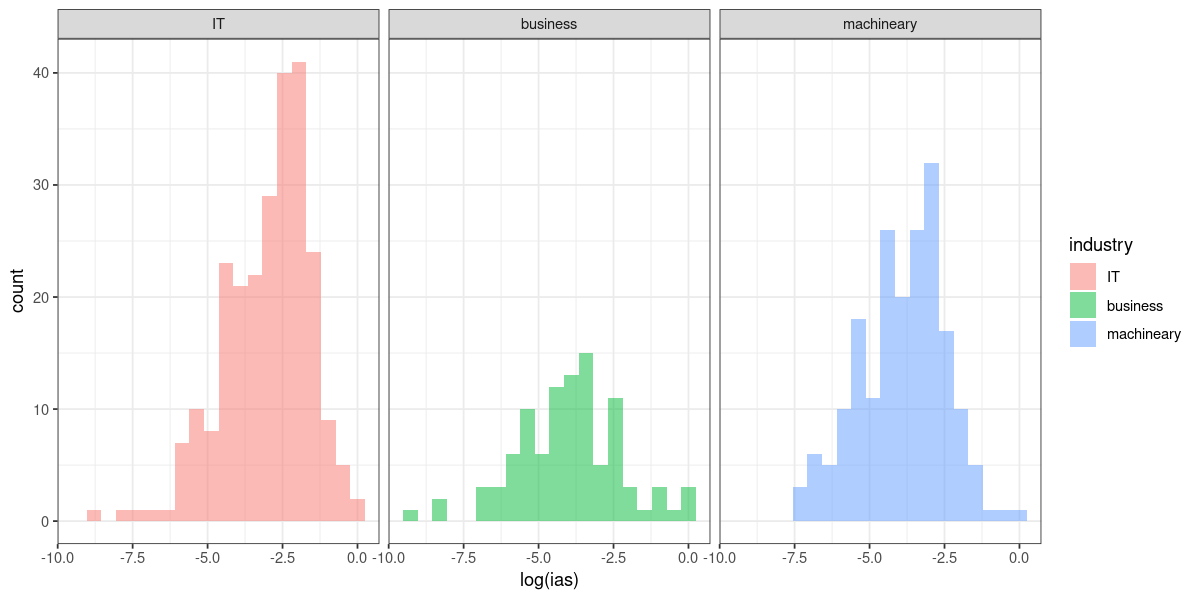

In [14]:
# we now want to check whether log(ias) is distributed similarly across industries
# here we will use ggplot2
options(repr.plot.width = 10, repr.plot.height = 5)
cis2 %>%
    .[ias > 0] %>%
    .[, .(ias, industry)] %>%
    ggplot(aes(x = log(ias), fill = industry)) +
    geom_histogram(bins = 20, alpha = 0.5) +
    facet_wrap(~industry, nrow = 1) +
    theme_bw()

For all industries, the shape is of bell shape. This means that they are more or less normally distributed after we:

- filter out the innovation intensity > 0
- take the log of innovation intensity

### From univariate to bivariate analysis

We now have a basic understanding of the distribution of innovation intensity. Now, we want to see how innovation intensity is related to other variables. We will focus on the following variables:

- bges: average number of employees (firm size)
- um:  Umsatz in Mio. Euro (turnover in million euro)
- exs: Exportquote (export ratio)
- lp: Laborproduktivitaet (labor productivity)
- invs: Investitionsquote (investment ratio)
- markets:  Marketingaufwendungen Intensitaet (marketing intensity)
- designs: Designaufwendungen Intensitaet (design intensity)
- softws: Softwareaufwendungen Intensitaet (software intensity)
- wbp: Weiterbildungskostenanteil (training intensity)
- fues:  Intensitaet FuE (R&D intensity)
- iainvs: Intensitaet investive Inno. (investment innovation intensity)

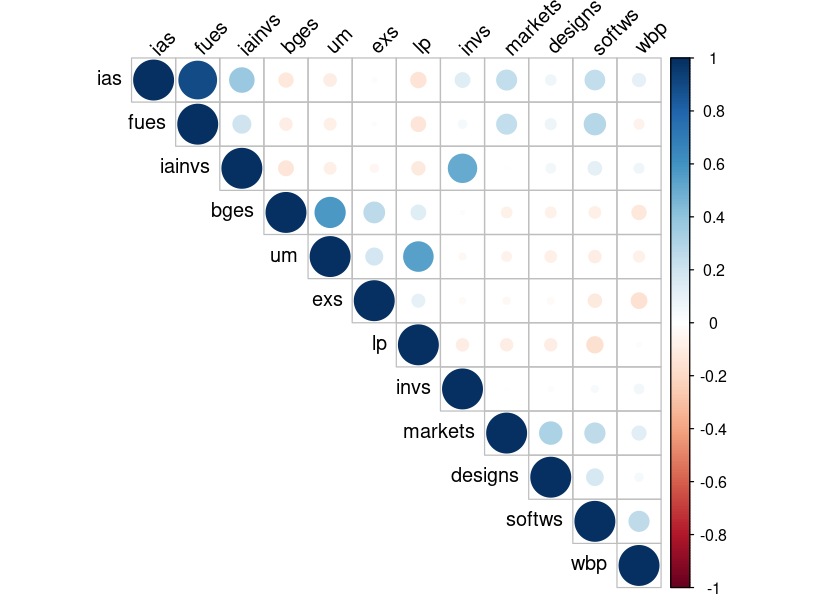

In [32]:
# check correlation between ias and other variables
cis2 %>%
    # only select firms that have ias > 0
    .[ias > 0] %>%
    # select variables we need
    .[, .(ias, fues, iainvs, bges, um, exs, lp, invs, markets, designs, softws, wbp)] %>%
    # check correlation without missing values
    cor(use = "pairwise.complete.obs") %>%
    # plot correlation matrix
    corrplot(method="circle", type="upper", tl.col="black", tl.srt=45)



As we can see that `ias` (innovation intensity) and `fues` (R&D intensity) are highly correlated. This is not surprising because R&D is the main source of innovation.


It is interesting that the correlation between `ias` and `lp` is very low and even
negative. This means that the more innovative firms are not necessarily more productive.
However, to be more accurate, we need to do a regression analysis.

In [16]:
# now we plot the scatter plot of ias and other variables
cis2 %>%
    .[, .(ias, markets)] %>%
    head()

ias,markets
<dbl>,<dbl>
0.120000000,NA
0.020220373,0.002829295
0.142699580,0.017154280
0.020420665,0.001565584
0.058788523,NA
0.005916505,0.001795862


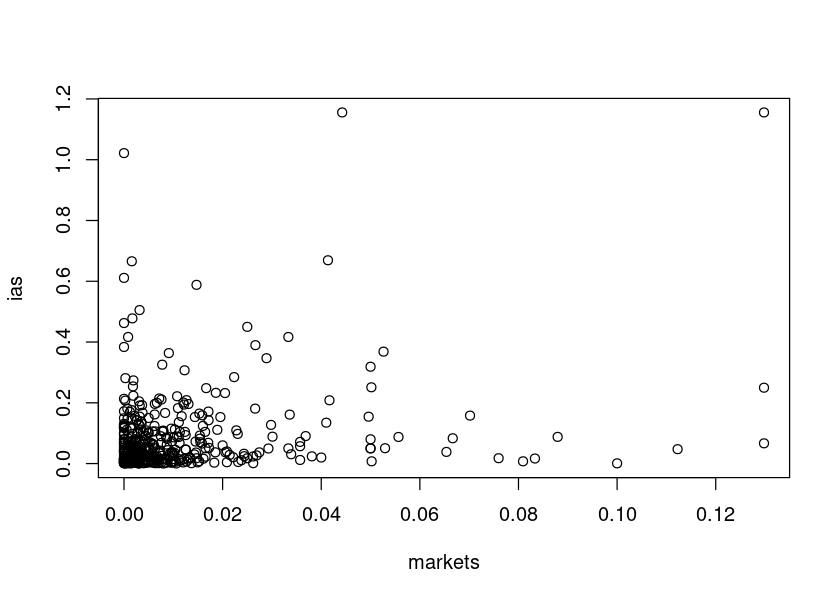

In [22]:
options(repr.plot.width = 7, repr.plot.height = 5)
cis2 %>%
    .[ias > 0] %>%
    .[, .(ias, markets)] %>%
    with(plot(markets, ias))

Overall, you can see that there is a positive relationship between `ias` and `markets`,
however, the relationship is not very strong.

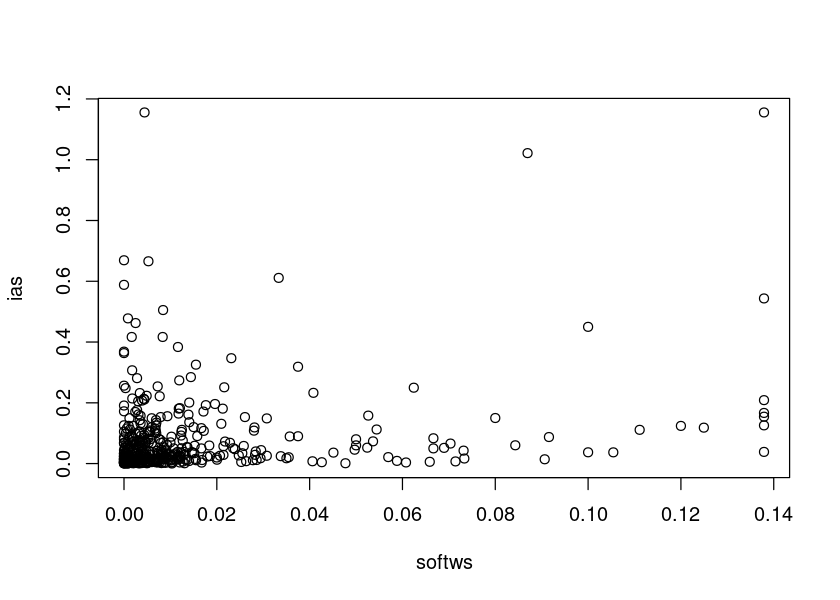

In [23]:
# ias and softws
options(repr.plot.width = 7, repr.plot.height = 5)
cis2 %>%
    .[ias > 0] %>%
    .[, .(ias, softws)] %>%
    with(plot(softws, ias))

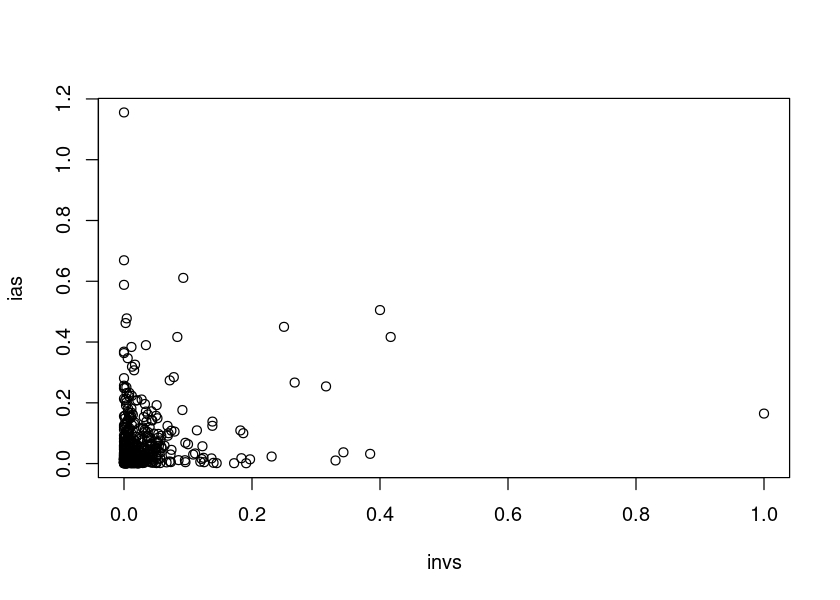

In [38]:
options(repr.plot.width = 7, repr.plot.height = 5)
cis2 %>%
    .[ias > 0] %>%
    .[, .(ias, invs)] %>%
    with(plot(invs, ias))

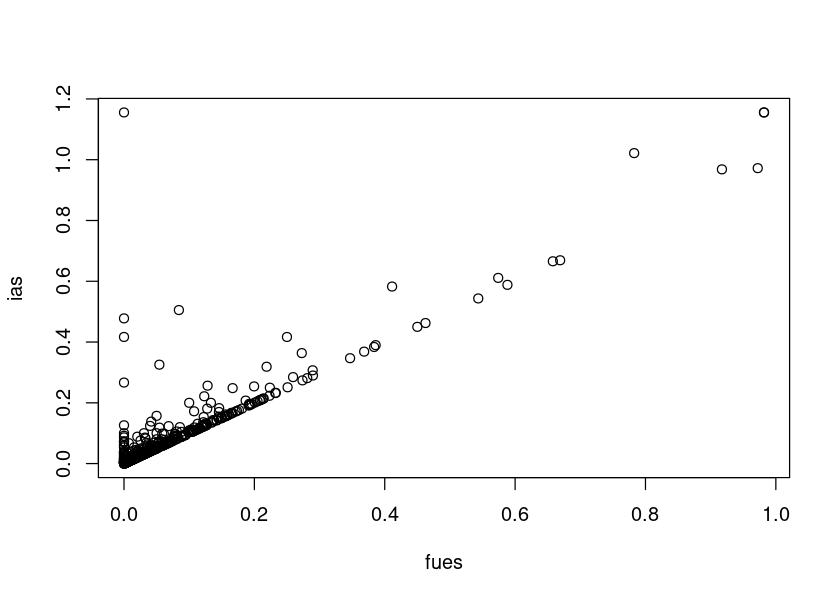

In [33]:
options(repr.plot.width = 7, repr.plot.height = 5)
cis2 %>%
    .[ias > 0] %>%
    .[, .(ias, fues)] %>%
    with(plot(fues, ias)) 

`fues` means R&D intensity. As you can see that there is a positive relationship between
`ias` and `fues`. The above graph shows those two factors are almost identical.

## 4. Introduction to regression analysis 

Many exam questions will be related to regression analysis. So, please pay attention to this section.
Before we run a regression analysis, let's first understand the basic concepts of regression analysis
via simulation.

We know that the relationship between `weight` and `height` is roughly linear and positive.
We will use this relationship to simulate the data. When we simulate the data, we will add some
random nosie to the data as there is no perfect linear relationship between `weight` and `height`.
To make you understand the concept, I will simulate the data step by step.

- scenario 1: no noise (perfect linear relationship)
- scenario 2: add some noise (not perfect linear relationship)
- scenario 3: add some outliers (not perfect linear relationship; TODO Later)

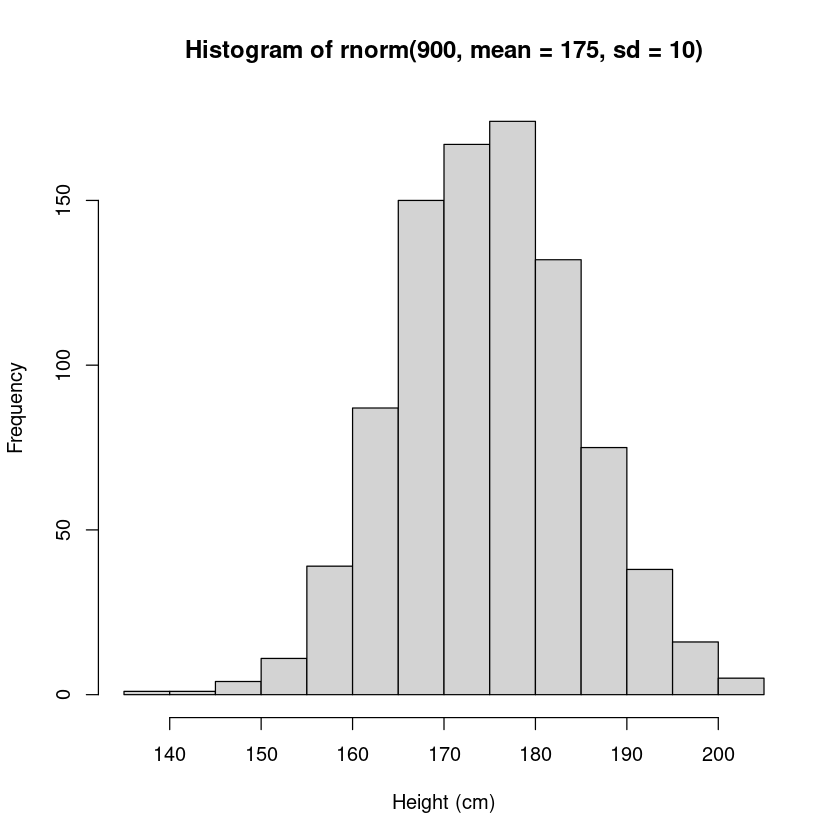

In [6]:
# rnorm = normal distribution function in R 
hist(rnorm(900, mean = 175, sd = 10), xlab="Height (cm)")

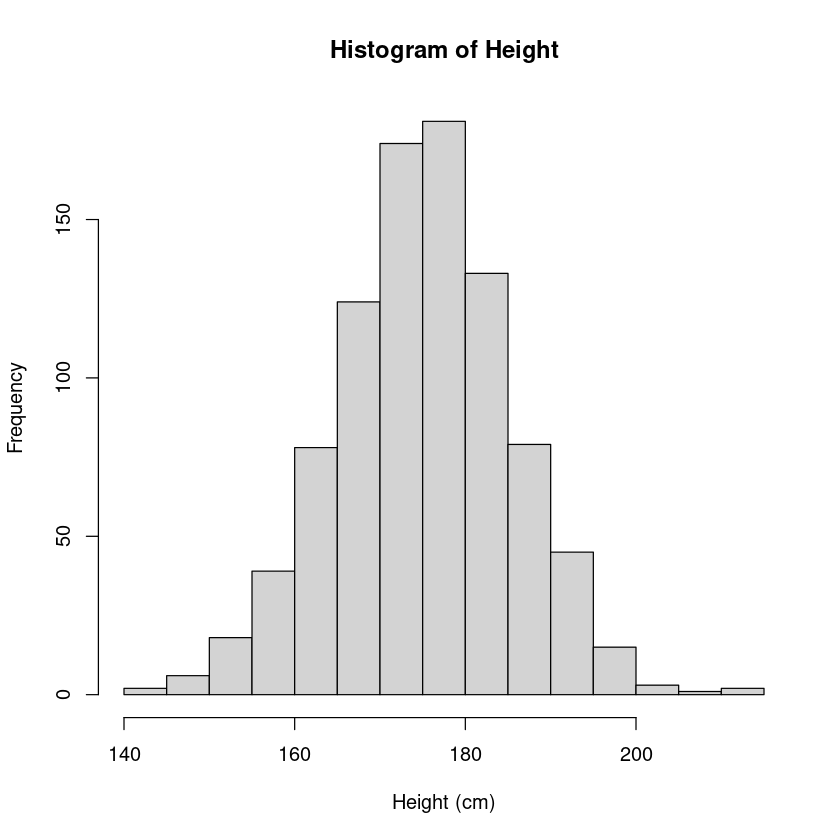

In [8]:
# simulate weight and height
# generate 900 random numbers from normal distribution
# mean =  175cm and sd = 10cm
height <- rnorm(900, mean = 175, sd = 10)
# plot histogram
hist(height, breaks = 20, xlab="Height (cm)", main="Histogram of Height")

Now, we have the height, we assume that there is a linear relationship between `height` and `weight`,
which has the following form:

$$
weight = \beta_0 + \beta_1 \times height
$$

Here we set $\beta_0 = 55$ and $\beta_1 = 0.1$. This means that if the height increases by 1 cm, the weight will increase by 0.1 kg.

$$
weight = 55 + 0.1 \times height
$$

It has the format:

$$
y = b + ax
$$

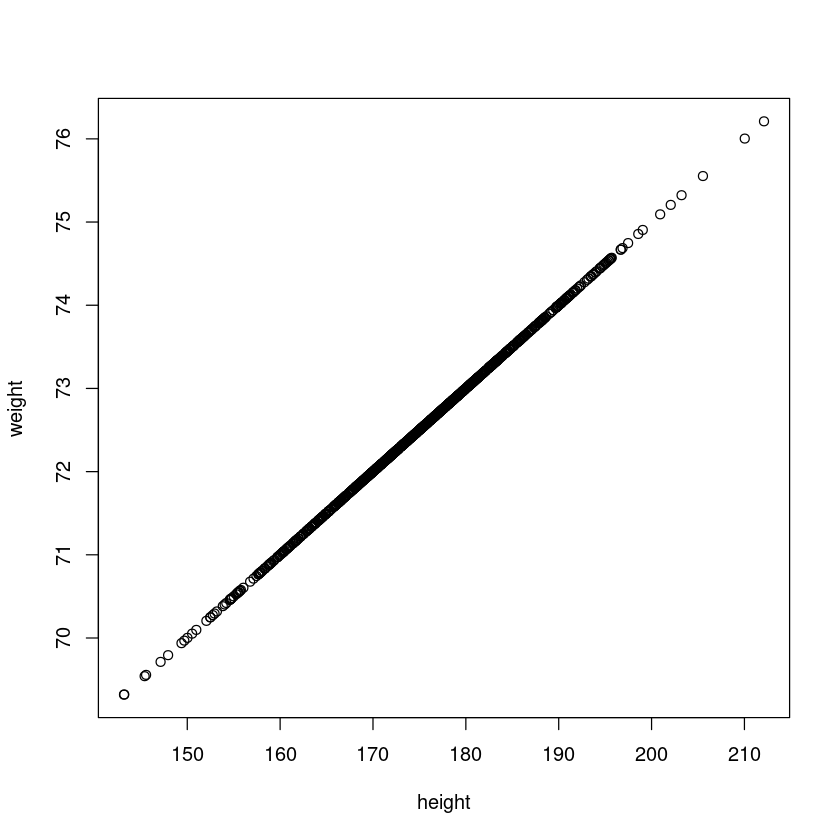

In [45]:
# generate weight
# CHANGE THE NUMBER AND PLAY WITH IT :) 
weight <- 55 + 0.1 * height

# plot scatter plot
plot(height, weight)

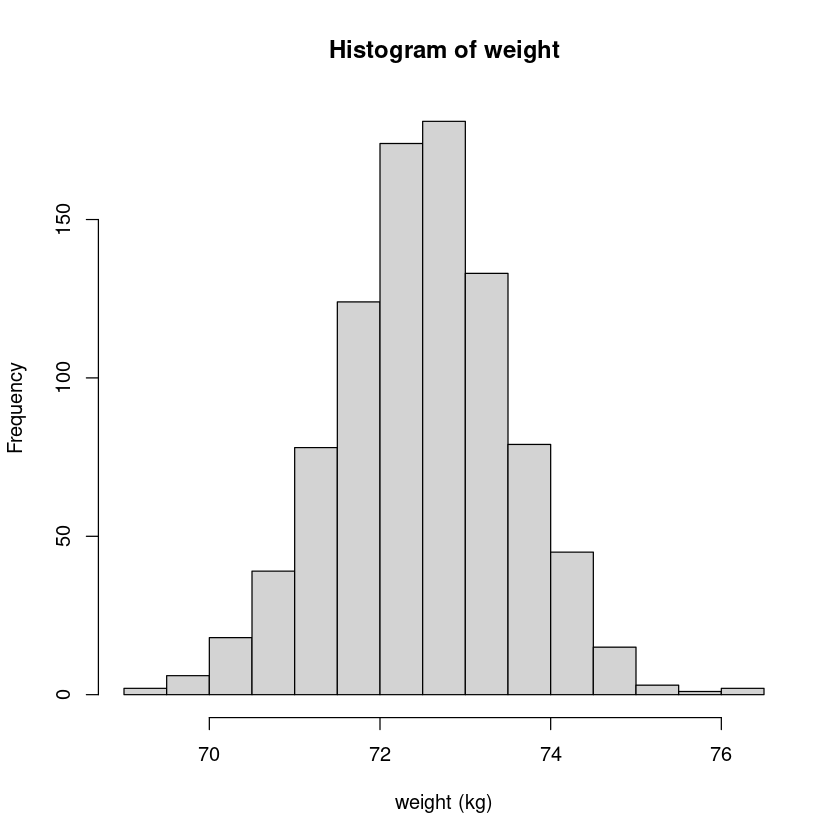

In [13]:
# plot histogram of weight
hist(weight, breaks = 20, xlab="weight (kg)")

In [46]:
# now let's fit a linear regression model
sm1 <- lm(weight ~ height)

stargazer(sm1, type = "text")


                                        Dependent variable:                     
                    ------------------------------------------------------------
                                               weight                           
--------------------------------------------------------------------------------
height                                        0.100***                          
                                              (0.000)                           
                                                                                
Constant                                     55.000***                          
                                              (0.000)                           
                                                                                
--------------------------------------------------------------------------------
Observations                                    900                             
R2                         

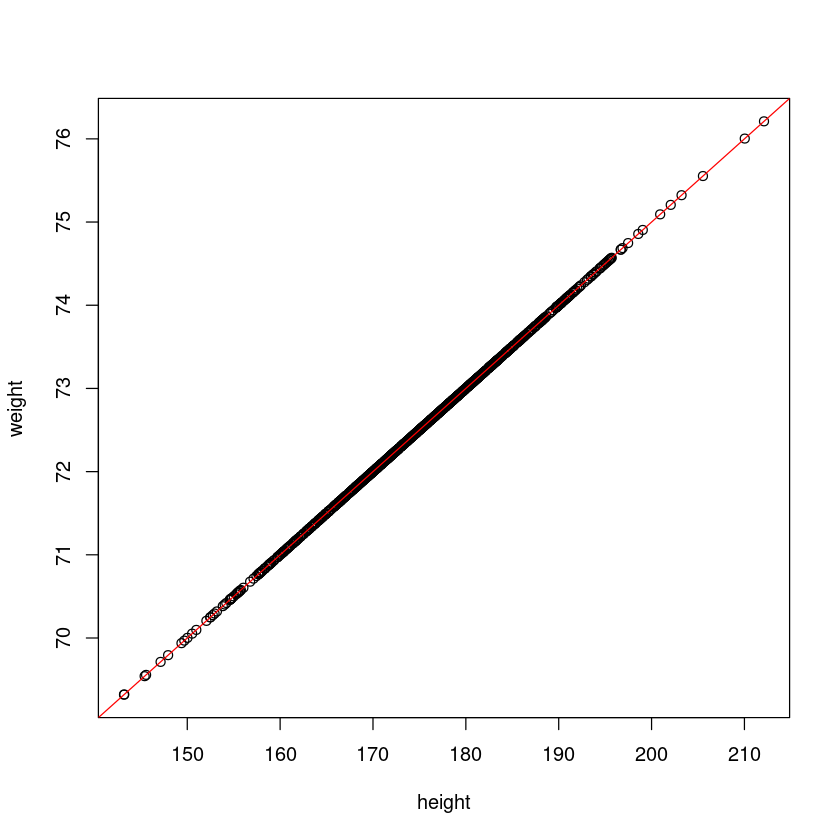

In [34]:
plot(height, weight)
abline(sm1, col='red')

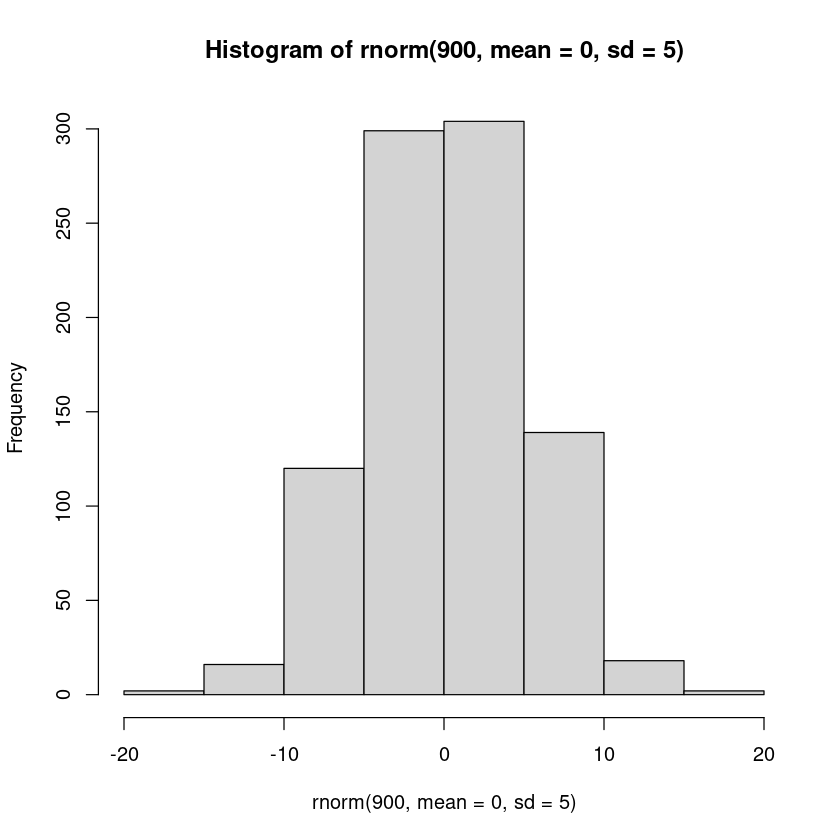

In [18]:
hist(rnorm(900, mean = 0, sd = 5))

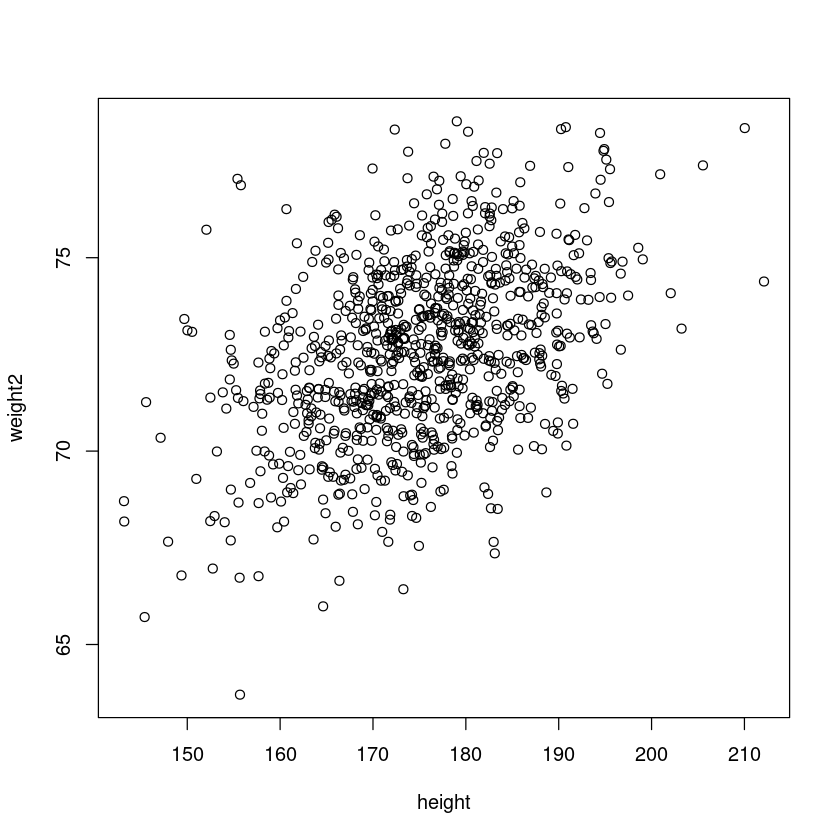

In [47]:
# add some noise to weight
# weight = 55 + 0.1 * height
# weight2 = weight + noize (rnorm)
weight2 <- weight + rnorm(900, mean = 0, sd = 2)

# plot scatter plot
plot(height, weight2)

In [48]:
# now we will fit linear regression with weight2 ~ height
sm2 <- lm(weight2 ~ height)

# print out the model
stargazer(sm2, type = "text")


                        Dependent variable:    
                    ---------------------------
                              weight2          
-----------------------------------------------
height                       0.094***          
                              (0.007)          
                                               
Constant                     56.162***         
                              (1.190)          
                                               
-----------------------------------------------
Observations                    900            
R2                             0.176           
Adjusted R2                    0.175           
Residual Std. Error      2.075 (df = 898)      
F Statistic          191.774*** (df = 1; 898)  
Note:               *p<0.1; **p<0.05; ***p<0.01


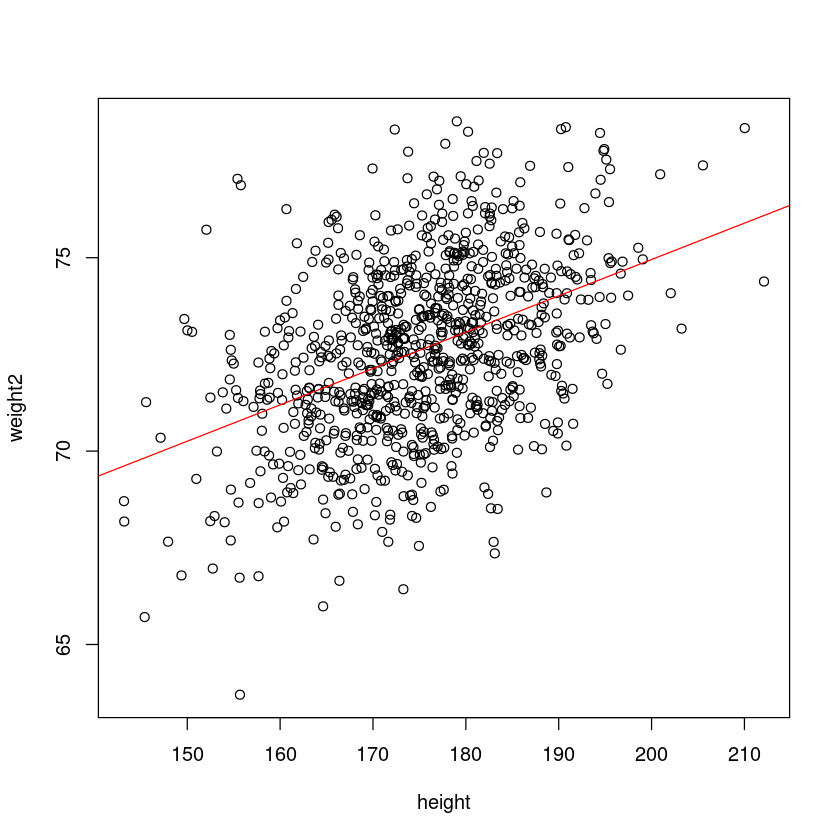

In [49]:
# add fitted line
plot(height, weight2)
# add model 
abline(sm2, col='red')

### Control variables (from one to two, then to three)

- univariate analysis (one variable)
- bivariate analysis (two variable)
- multivatte anaysis (more than two)

Let's review what we have done:

1. simulate one variable (height, follows the normal distribution)

$$height \sim N(175, 10)$$

2. assume there is a perfect linear relationship between `weight` and `height` such as

$$
weight = 55 + 0.1 * height 
$$

3. add noise into the data because there is no perfect thing in the real life (except for the GOD)

$$
weight = 55 + 0.1 * height + \epsilon; \quad \epsilon \sim N(0, 2)
$$

4. bring one more variable into our analysis, let's say gender (female/male)

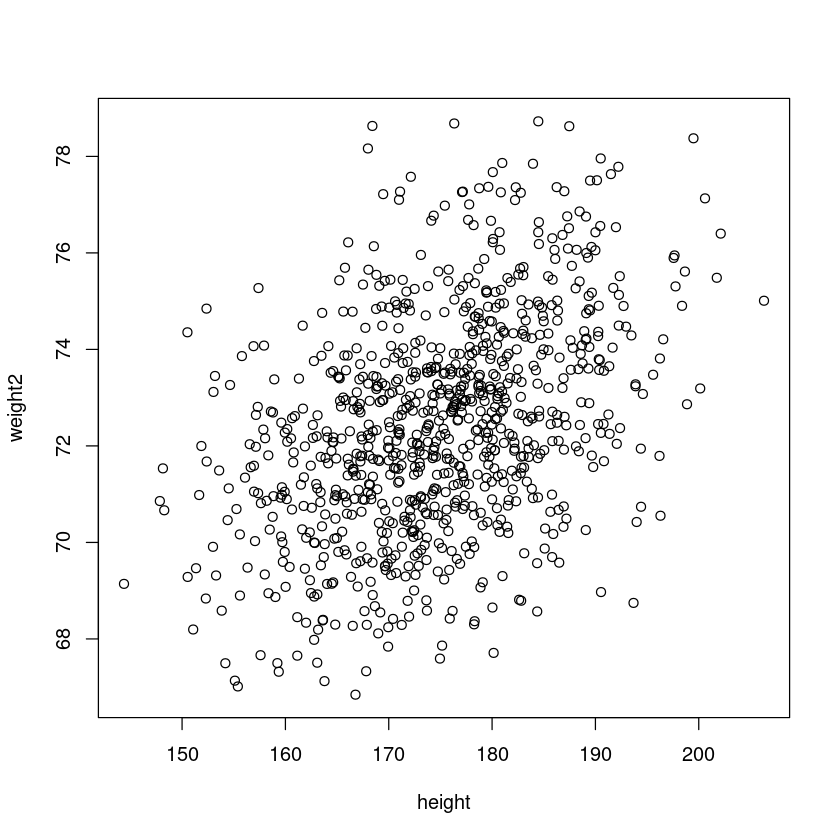

In [51]:
height <- rnorm(900, mean=175, sd=10)
weight <- 55 + 0.1* height 
weight2 <- weight + rnorm(900,0, 2)
plot(height, weight2)

### Control variables (from one to two, then to three)

- univariate analysis (one variable)
- bivariate analysis (two variable)
- multivatte anaysis (more than two)

Let's review what we have done:

1. simulate one variable (height, follows the normal distribution)

$$height \sim N(175, 10)$$

2. assume there is a perfect linear relationship between `weight` and `height` such as

$$
weight = 55 + 0.1 \times height 
$$

3. add noise into the data because there is no perfect thing in the real life (except for the GOD)

$$
weight = 55 + 0.1 \times height + \epsilon; \quad \epsilon \sim N(0, 2)
$$

4. bring one more variable into our analysis, let's say gender (female/male)

5. for female, the distribution of height might be different from male

6. the relationship between height and weight is different for female and male

__You can see that the complexity has already kicks in even for onlhy three variables__. 

In [56]:
# generate height for female
height_female <- rnorm(450, 170, 5)
female_character <- rep("female", 450)
height_male <- rnorm(450, 175, 10)
male_character <- rep('male', 450)
# put them together as a data.frame and then conver it to the data.table
sim_data <- data.frame(height = c(height_female, height_male), gender = c(female_character, male_character))
sim_data <- as.data.table(sim_data)
head(sim_data)

height,gender
<dbl>,<chr>
157.5263,female
171.3302,female
168.2083,female
168.1971,female
160.0698,female
176.4873,female


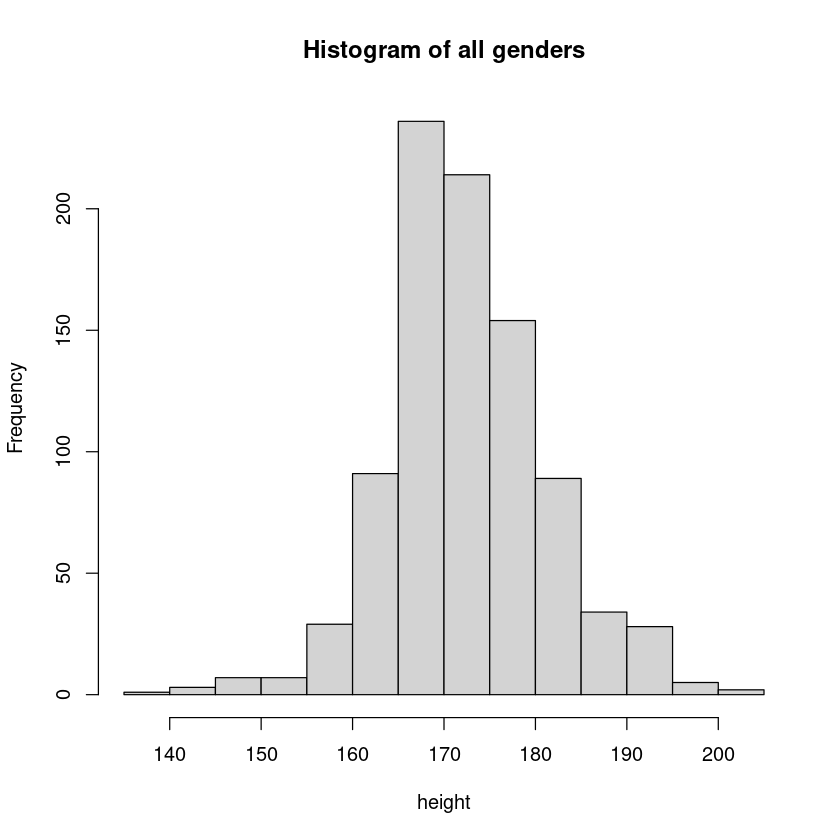

In [60]:
sim_data %>%
    with(hist(height, main="Histogram of all genders"))

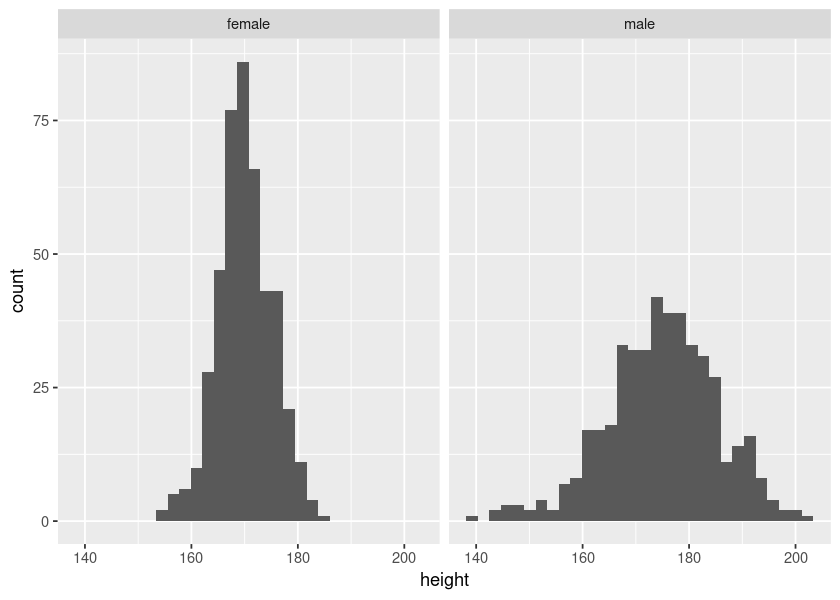

In [67]:
options(repr.plot.width = 7, repr.plot.height = 5)
sim_data %>%
    ggplot(aes(x=height)) +
    geom_histogram(bins=30) + 
    facet_wrap(~gender)

### Control variables (from one to two, then to three)

- univariate analysis (one variable)
- bivariate analysis (two variable)
- multivatte anaysis (more than two)

Let's review what we have done:

1. simulate one variable (height, follows the normal distribution)

$$height \sim N(175, 10)$$

2. assume there is a perfect linear relationship between `weight` and `height` such as

$$
weight = 55 + 0.1 * height 
$$

3. add noise into the data because there is no perfect thing in the real life (except for the GOD)

$$
weight = 55 + 0.1 * height + \epsilon; \quad \epsilon \sim N(0, 2)
$$

4. bring one more variable into our analysis, let's say gender (female/male)

5. for female, the distribution of height might be different from male

$$
height_f \sim N(170, 5); \quad height_m \sim N(175, 10)
$$

6. the relationship between height and weight is different for female and male

$$
weight_f = 50 + 0.09 * height_f; \quad weight_m = 55 + 0.1 * height_m
$$

__You can see that the complexity has already kicks in even for onlhy three variables__. 

In [68]:
head(sim_data)

height,gender
<dbl>,<chr>
157.5263,female
171.3302,female
168.2083,female
168.1971,female
160.0698,female
176.4873,female


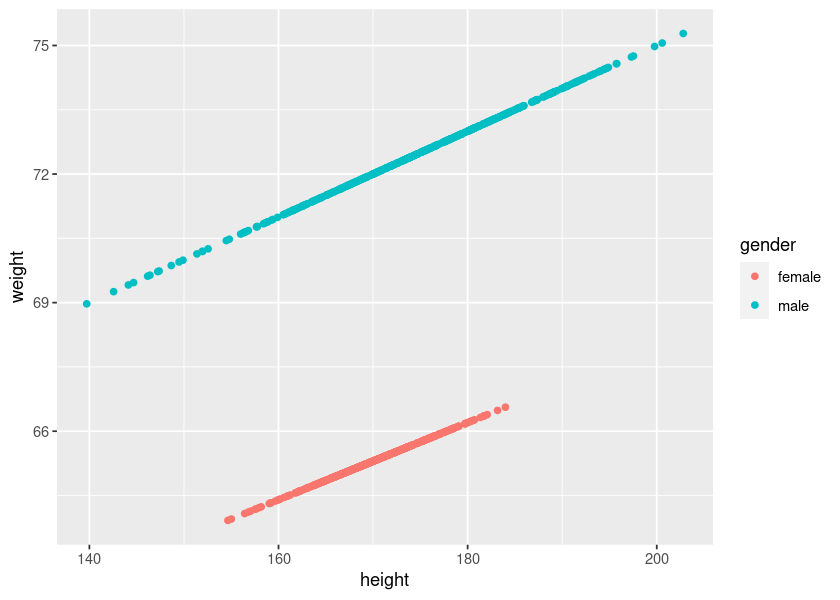

In [79]:
# add weight
sim_data %>%
    #[i, j, by]
    .[, weight := ifelse(gender=="female", 50 + 0.09*height, 55 + 0.1 * height)] %>%
    ggplot(aes(x=height, y=weight, color=gender)) + 
    geom_point()

In [102]:
# generate height for female
height_female <- rnorm(450, 170, 5)
female_character <- rep("female", 450)
height_male <- rnorm(450, 175, 10)
male_character <- rep('male', 450)
# put them together as a data.frame and then conver it to the data.table
sim_data <- data.frame(height = c(height_female, height_male), gender = c(female_character, male_character))
sim_data <- as.data.table(sim_data)

sim_data %>%
    #[i, j, by]
    .[, weight := ifelse(gender=="female", 50 + 0.09 *height, 55 + 0.1 * height)] -> sim_data2

str(sim_data2)

Classes ‘data.table’ and 'data.frame':	900 obs. of  3 variables:
 $ height: num  170 177 174 167 172 ...
 $ gender: chr  "female" "female" "female" "female" ...
 $ weight: num  65.3 65.9 65.7 65.1 65.5 ...
 - attr(*, ".internal.selfref")=<externalptr> 


In [81]:
head(sim_data2)

height,gender,weight
<dbl>,<chr>,<dbl>
166.2144,female,64.95930
177.0607,female,65.93546
170.5742,female,65.35168
170.5557,female,65.35001
171.6596,female,65.44936
163.3003,female,64.69703


We now assume that relationship between `weight` and `height` following the simple linear one:

$$
weight = \beta_0 + \beta_1 height + \epsilon; \quad \epsilon \sim N(0, sd)
$$

In [103]:
# sim_data2 has gender property
sm3 <- lm(weight ~ height, data=sim_data2)
stargazer(sm3, type="text")


                        Dependent variable:    
                    ---------------------------
                              weight           
-----------------------------------------------
height                       0.216***          
                              (0.013)          
                                               
Constant                     31.568***         
                              (2.233)          
                                               
-----------------------------------------------
Observations                    900            
R2                             0.238           
Adjusted R2                    0.237           
Residual Std. Error      3.213 (df = 898)      
F Statistic          280.045*** (df = 1; 898)  
Note:               *p<0.1; **p<0.05; ***p<0.01


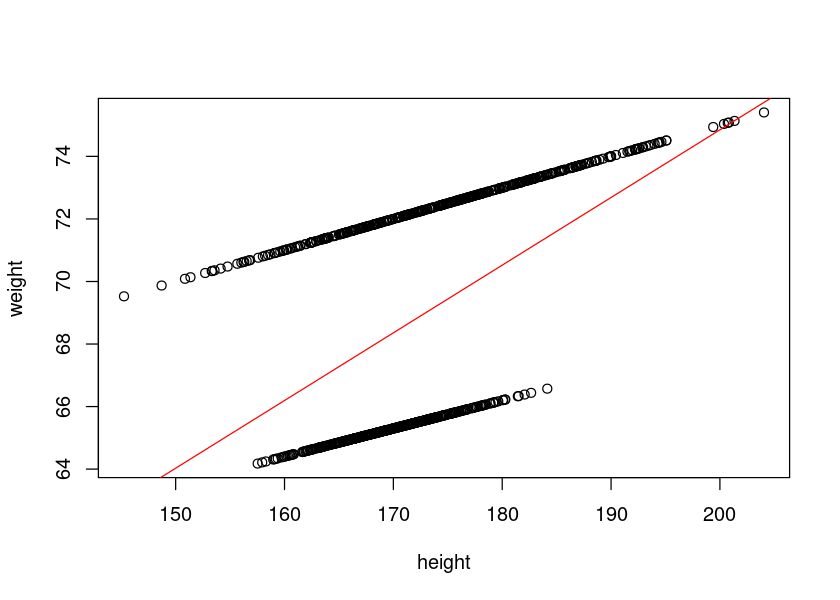

In [104]:
sim_data2 %>%
    with(plot(height, weight)) 
abline(sm3, col='red')

### Control variable

Control variable is a variable that is included in a statistical or research analysis to account for potential confounding factors or to assess the relationship between the independent and dependent variables __while holding other factors constant__. In the regression analysis we control different factors by adding control variables:

$$
weight = \beta_0 + \beta_1 height + \beta_2 gender + \epsilon
$$

In [90]:
head(sim_data2)

height,gender,weight
<dbl>,<chr>,<dbl>
166.2144,female,64.95930
177.0607,female,65.93546
170.5742,female,65.35168
170.5557,female,65.35001
171.6596,female,65.44936
163.3003,female,64.69703


6. the relationship between height and weight is different for female and male

$$
weight_f = 50 + 0.09 * height_f; \quad weight_m = 55 + 0.1 * height_m
$$

$$
weight = 48.63 + 0.098 * height + 6.7 * gender_m
$$

if $gender_m =1$ we will have

$$
weight = 48.63 + 0.098 * height + 6.7 = 55.337 +  0.098 * height
$$

In [105]:
# adding gender as control variable
sm4 <- lm(weight ~ height + gender, data=sim_data2)
stargazer(sm4, type="text")


                         Dependent variable:      
                    ------------------------------
                                weight            
--------------------------------------------------
height                         0.098***           
                               (0.0001)           
                                                  
gendermale                     6.710***           
                               (0.002)            
                                                  
Constant                      48.617***           
                               (0.022)            
                                                  
--------------------------------------------------
Observations                     900              
R2                              1.000             
Adjusted R2                     1.000             
Residual Std. Error        0.031 (df = 897)       
F Statistic         6,353,188.000*** (df = 2; 897)
Note:                  *p<0.1;

Warning message in abline(sm4, col = "red"):
“only using the first two of 3 regression coefficients”


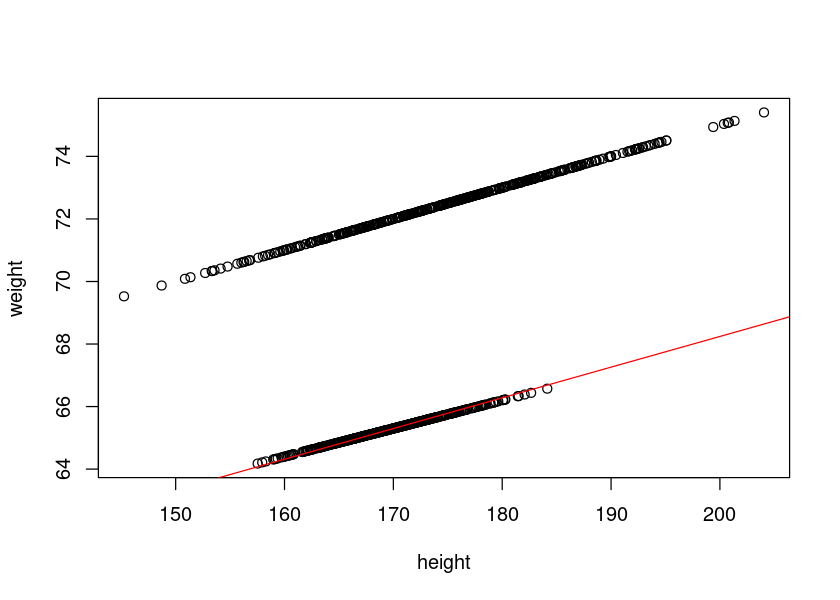

In [106]:
sim_data2 %>%
    with(plot(height, weight)) 
abline(sm4, col='red')

### Summary

- univariate (one- D)
- bivariate (two: D and A)
- multivariate (more than two, such as three: D - A and B) 

The relationship between `weight` (D) and `height` (A) is different for different genders (B). This kind of framework is very common for many regression analysis:

- __relationship between innovation (measured by patent numbers) and export intensity could be different for different
industries__

$$
innovation = \beta_0 + \beta_1 exportIntensity + \beta_2 industry + \beta_3 firmSize + ... + \epsilon 
$$

### Interpretation of regression analysis


__It is very important to know how to interpret the regression analysis results__. Again,
here we are __not talking about__ the causal relationship, but __the association between the dependent
variable and independent variables__. We will use an example to show you. 

The dataset we will explore is about the relationship between wage and education. Based 
on our common sense, it is likely that the more education is normally __associated__ with higher wage.

In [7]:
# install a new package called wooldridge
install.packages("wooldridge")

Installing package into '/usr/local/lib/R/site-library'
(as 'lib' is unspecified)



In [4]:
library(wooldridge)
# load the data
data("wage1")
# convert it to data.table
wage1 <- as.data.table(wage1)

In [5]:
head(wage1)

wage,educ,exper,tenure,nonwhite,female,married,numdep,smsa,northcen,⋯,trcommpu,trade,services,profserv,profocc,clerocc,servocc,lwage,expersq,tenursq
<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<int>,<int>
3.10,11,2,0,0,1,0,2,1,0,⋯,0,0,0,0,0,0,0,1.131402,4,0
3.24,12,22,2,0,1,1,3,1,0,⋯,0,0,1,0,0,0,1,1.175573,484,4
3.00,11,2,0,0,0,0,2,0,0,⋯,0,1,0,0,0,0,0,1.098612,4,0
6.00,8,44,28,0,0,1,0,1,0,⋯,0,0,0,0,0,1,0,1.791759,1936,784
5.30,12,7,2,0,0,1,1,0,0,⋯,0,0,0,0,0,0,0,1.667707,49,4
8.75,16,9,8,0,0,1,0,1,0,⋯,0,0,0,1,1,0,0,2.169054,81,64


As we can see that we have many variables, however we are mainly interested in the relationship between `wage` and `education`, so we will only focus on these two variables and other control variables such as:


- wage: average hourly earnings
- educ: years of education
- exper: years of experience
- female: =1 if female otherwise =0

In [6]:
wage1 %>%
    # lwage = log transformation of wage 
    .[, .(wage, educ, exper, female, lwage)] %>%
    head()

wage,educ,exper,female,lwage
<dbl>,<int>,<int>,<int>,<dbl>
3.10,11,2,1,1.131402
3.24,12,22,1,1.175573
3.00,11,2,0,1.098612
6.00,8,44,0,1.791759
5.30,12,7,0,1.667707
8.75,16,9,0,2.169054


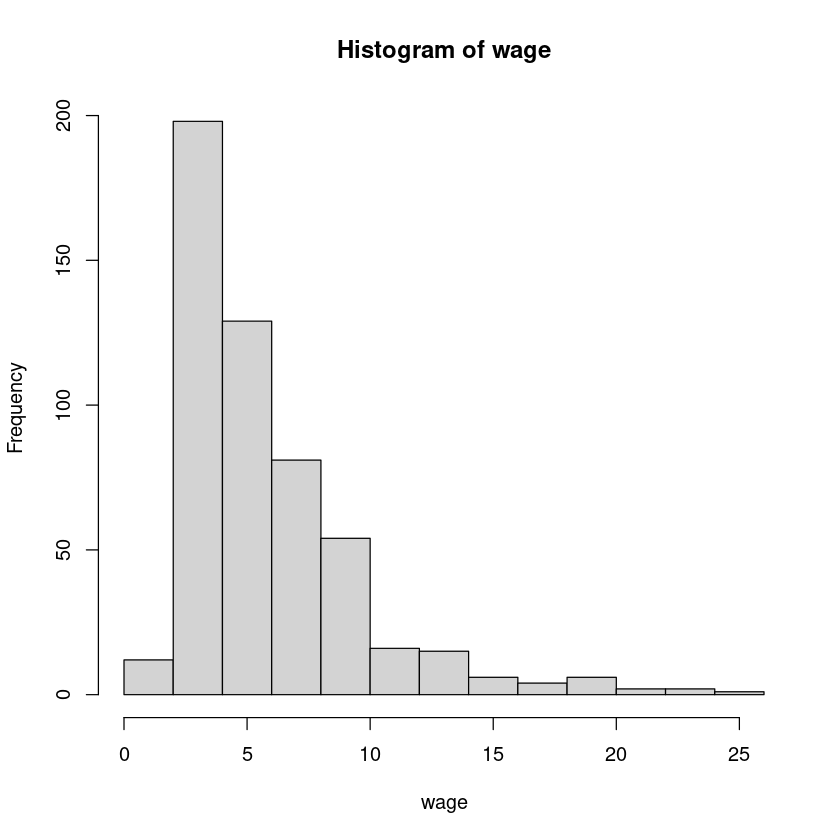

In [12]:
# univariate anlaysis
wage1 %>%
    with(hist(wage))

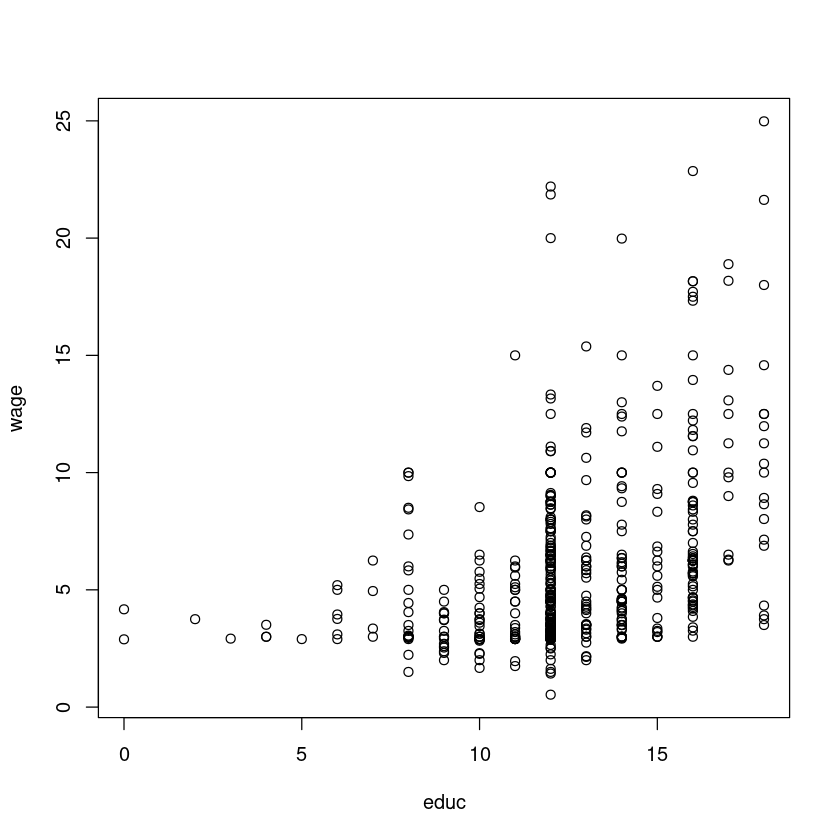

In [14]:
# bivariate analysis
wage1 %>%
    with(plot(educ, wage))

In [7]:
# run regression
wage_reg1 <- lm(wage ~ educ, data=wage1)

stargazer(wage_reg1, type="text")


                        Dependent variable:    
                    ---------------------------
                               wage            
-----------------------------------------------
educ                         0.541***          
                              (0.053)          
                                               
Constant                      -0.905           
                              (0.685)          
                                               
-----------------------------------------------
Observations                    526            
R2                             0.165           
Adjusted R2                    0.163           
Residual Std. Error      3.378 (df = 524)      
F Statistic          103.363*** (df = 1; 524)  
Note:               *p<0.1; **p<0.05; ***p<0.01


The model predicts that __an increase in education of 1 year is associated with an increase of 0.5411 dollar an hour in wage__. The intercept of −0.9049 literally means that a person with no education has a predicted hourly wage of −90 cent an hour. __This, of course, is silly. Therefore, we must interpret this equation with caution__.

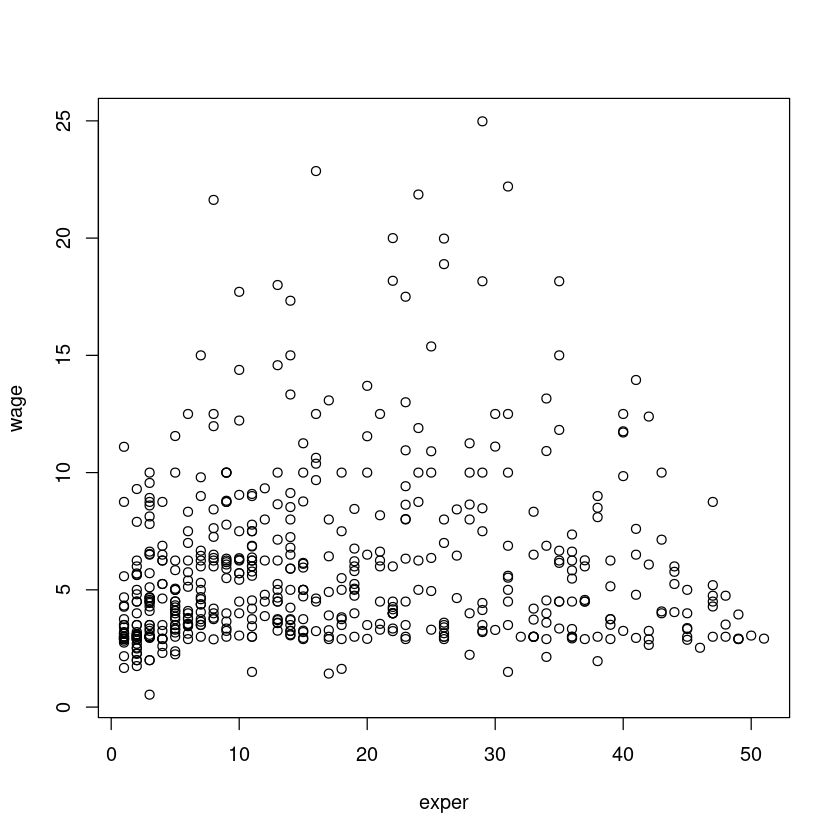

In [16]:
# now we continue to explore relationship between wage and exper
# bivariate: experience and wage 
wage1 %>%
    with(plot(exper, wage))

Here we notice that there is some __nonlinear relationship__ between `wage` and `exper`,
which is not surprising. The wage normally increases with experience, but it will stop 
after reaching a certain level. For instance, most people will not get a higher wage after
working for 20 to 30 years (say after 60 years old).

In [8]:
# let's run regression
wage_reg2 <- lm(wage ~ educ + exper, data=wage1)

stargazer(wage_reg2, type="text")


                        Dependent variable:    
                    ---------------------------
                               wage            
-----------------------------------------------
educ                         0.644***          
                              (0.054)          
                                               
exper                        0.070***          
                              (0.011)          
                                               
Constant                     -3.391***         
                              (0.767)          
                                               
-----------------------------------------------
Observations                    526            
R2                             0.225           
Adjusted R2                    0.222           
Residual Std. Error      3.257 (df = 523)      
F Statistic           75.990*** (df = 2; 523)  
Note:               *p<0.1; **p<0.05; ***p<0.01


In [9]:
# let's add non-linear term
wage_reg3 <- lm(wage ~ educ + exper + I(exper^2), data=wage1)

stargazer(wage_reg3, type="text")


                        Dependent variable:    
                    ---------------------------
                               wage            
-----------------------------------------------
educ                         0.595***          
                              (0.053)          
                                               
exper                        0.268***          
                              (0.037)          
                                               
I(exper2)                    -0.005***         
                              (0.001)          
                                               
Constant                     -3.965***         
                              (0.752)          
                                               
-----------------------------------------------
Observations                    526            
R2                             0.269           
Adjusted R2                    0.265           
Residual Std. Error      3.166 (df = 52

With this model, here is how we will interpret the results: __holding other factors constant, an increase in education of 1 year is associated with an increase of 0.595 dollar an hour in wage__. The coefficient is significant at 1% level. For
experience, we can say that __holding other factors constant, there is an nonlinear relationship between experience and wage__. The wage will increase with experience, but it will stop after reaching a certain level.

The coefficients for `exper` and `exper2` are $0.268$ and $-0.005$, now let's plot the relationship between `wage` and `exper` holding other factors constant. This means we can have the following equation:

$$
wage = 0.268 \times exper - 0.005 \times exper^2
$$

In [12]:
seq(0, 10, 1)

[1]  0  1  2  3  4  5  6  7  8  9 10

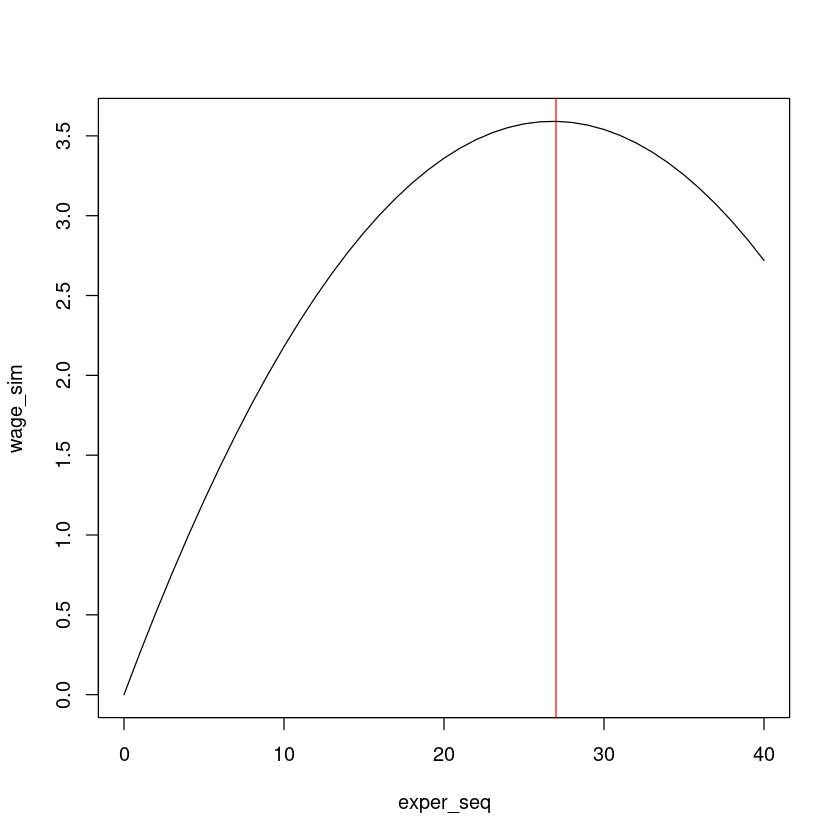

In [16]:
# simulate experience from 0 to 40 years
# seq = sequence generated from 0 to 30 with interval 1
exper_seq <- seq(0, 40, 1)
# ^2 means square
wage_sim <- 0.268 * exper_seq - 0.005 * exper_seq^2

# plot the relationship
plot(exper_seq, wage_sim, type="l")

# add vertical line
abline(v=27, col='red')

The model we estimated shows that the wage level stops increasing after 27 years of experience. You will not be aksed to do this kind of estimation in the exam. However, it is important to know how to interpret the regression results.
__Normally, many variables related to age and experienceare have properities of nonlinear__. For instance, the relationship between `wage` and `age` is nonlinear. The wage will increase with age, but it will stop after reaching a certain level.

integer(0)

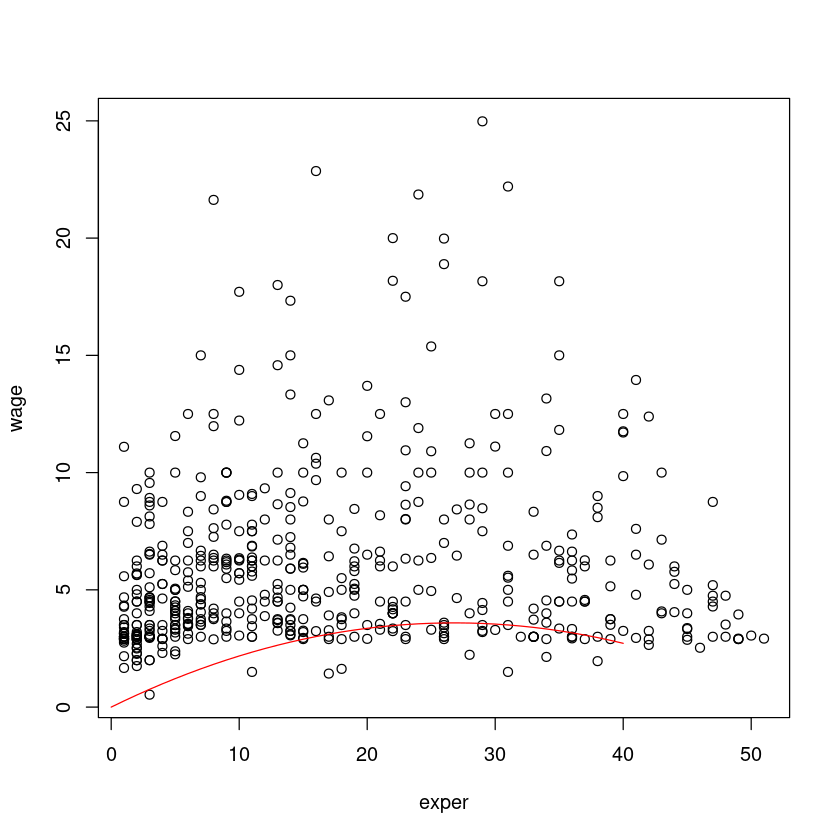

In [30]:
# we can put them together
wage1 %>%
    with(plot(exper, wage)) +
    lines(exper_seq, wage_sim, type="l", col='red')

Why the red curve above does not fit with the dataset exactly? Wage is real-lfe data, it is determined:

- educ
- experience
- industry
- networking
- other factors 

In the above model, the red curve was generated based on only factor `exper`:

$$
wage = 0.268 \times exper - 0.005 \times exper^2
$$

Here we only plot the relationship between `wage` and `exper` without considering other factors.
Be aware that `wage` is the average hourly earnings, which is from the real data. `wage`
is determined by many factors, such as education and industry. Now, image let's assume
__the wage was determined by the following equaion__:

$$
wage = 10+  0.268 \times exper - 0.005 \times exper^2
$$

This means that we have nonlinear relationship between `wage` and `exper`. The wage will increase with experience, but it will stop after reaching a certain level. Then, no matter what kind of industry you are in,
or degree you have, the relationship between `wage` and `exper` will be the same and everyone
will be added $10$ dollars per hour as a constant.

integer(0)

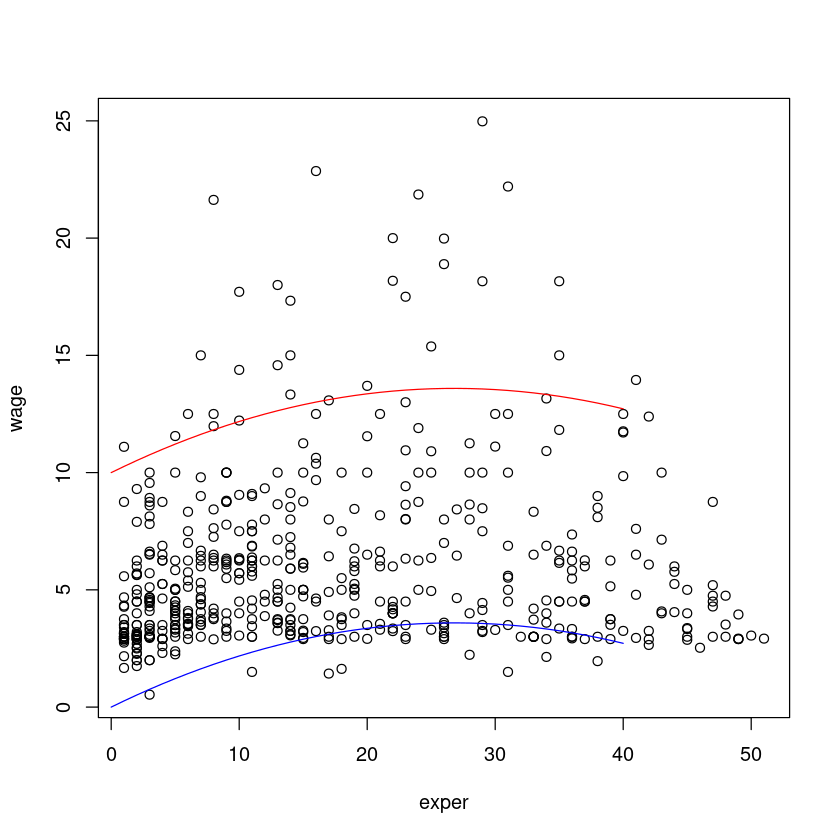

In [21]:
# let's simulate the above equation 
wage_sim2 <- 10 + 0.268 * exper_seq - 0.005 * exper_seq^2

# then we plot it again 
wage1 %>%
    with(plot(exper, wage)) +
    lines(exper_seq, wage_sim2, type="l", col='red') + 
    lines(exper_seq, wage_sim, type="l", col='blue') 

We have controled the experience, here is the short summary of the regression results:

give me a table with four columns and three rows

| dependent variable | independent variable of interested | control variable1 | control variable2 |
| --- | --- | --- | --- |
| wage | education: 0.541***  | | | 
| wage | eductation: 0.644***  | exper:  0.070*** | |
| wage | eductation: 0.595*** | exper:0.268*** | exper2: -0.005***  |

__The regression results are not causal__, but they are useful for us to understand the relationship between dependent variable and independent variables. Here we can be very confident to say that
__holding other factors constant, there is a very strong positive association between education and wage__. The reason is that the coefficient of education __did not change much__ when we add more control variables (such as experience). This means whether for people who have more experience or not, the education is still __positively associated__ with wage.

Now, how about the gender? __Does the relationship still hold for different genders?__ Let's run another regression analysis.

In [22]:
# add gender in the regression
wage_reg4 <- lm(wage ~ educ + exper + I(exper^2) + female, data=wage1)

stargazer(wage_reg4, type="text")


                        Dependent variable:    
                    ---------------------------
                               wage            
-----------------------------------------------
educ                         0.556***          
                              (0.050)          
                                               
exper                        0.255***          
                              (0.035)          
                                               
I(exper2)                    -0.004***         
                              (0.001)          
                                               
female                       -2.114***         
                              (0.263)          
                                               
Constant                     -2.319***         
                              (0.739)          
                                               
-----------------------------------------------
Observations                    526    

Here we notice that the coefficient for female is $-2.114$, which means __holding other 
factors constant, women is associated with a decrease of 2.114 dollar an hour in wage comparing to men__.
__This means even with same education, experience, there is still negative association between being female and 
wage__. Therefore, we can say this might be due to the gender discrimination in the labor market.

In [24]:
# now, let's put all tables together
stargazer(wage_reg1, wage_reg2, wage_reg3, wage_reg4, type="text")


                                                          Dependent variable:                                       
                    ------------------------------------------------------------------------------------------------
                                                                  wage                                              
                              (1)                      (2)                     (3)                     (4)          
--------------------------------------------------------------------------------------------------------------------
educ                        0.541***                0.644***                0.595***                0.556***        
                            (0.053)                  (0.054)                 (0.053)                 (0.050)        
                                                                                                                    
exper                                               0.070***   

### Robustness check

__Robustness check__ is a very important concept in regression analysis. It is very important to check whether the results are robust to different specifications. For instance, we can run the regression analysis with different control variables. If the results are robust, then we can be more confident about the results.

### Regression diagnostics

After running the regression analysis, we need to check whether the results are reliable. There are many ways to check the reliability of the results. Here we will introduce two ways:

- __residual plot__: the residual plot is used to check whether the residuals are randomly distributed. If the residuals are randomly distributed, then we can say the results are reliable. Otherwise, we need to check the model specification. For instance, we might need to add more control variables to the model.

- __VIF__: VIF is used to check whether there is multicollinearity in the model. If the VIF is larger than 10, then we need to check whether there is multicollinearity in the model. If there is multicollinearity, then we need to remove some variables from the model.

The residuals are just nosize we assumed in the model:

$$
\begin{aligned}
wage & = \beta_0 + \beta_1 educ + \beta_2 exper + \beta_3 exper^2 + \beta_4 female + \epsilon; \quad  \epsilon \sim N(0, \sigma^2) \\
wage - (\beta_0 + \beta_1 educ + \beta_2 exper + \beta_3 exper^2 + \beta_4 female) & = \epsilon \sim N(0, \sigma^2)
\end{aligned}
$$

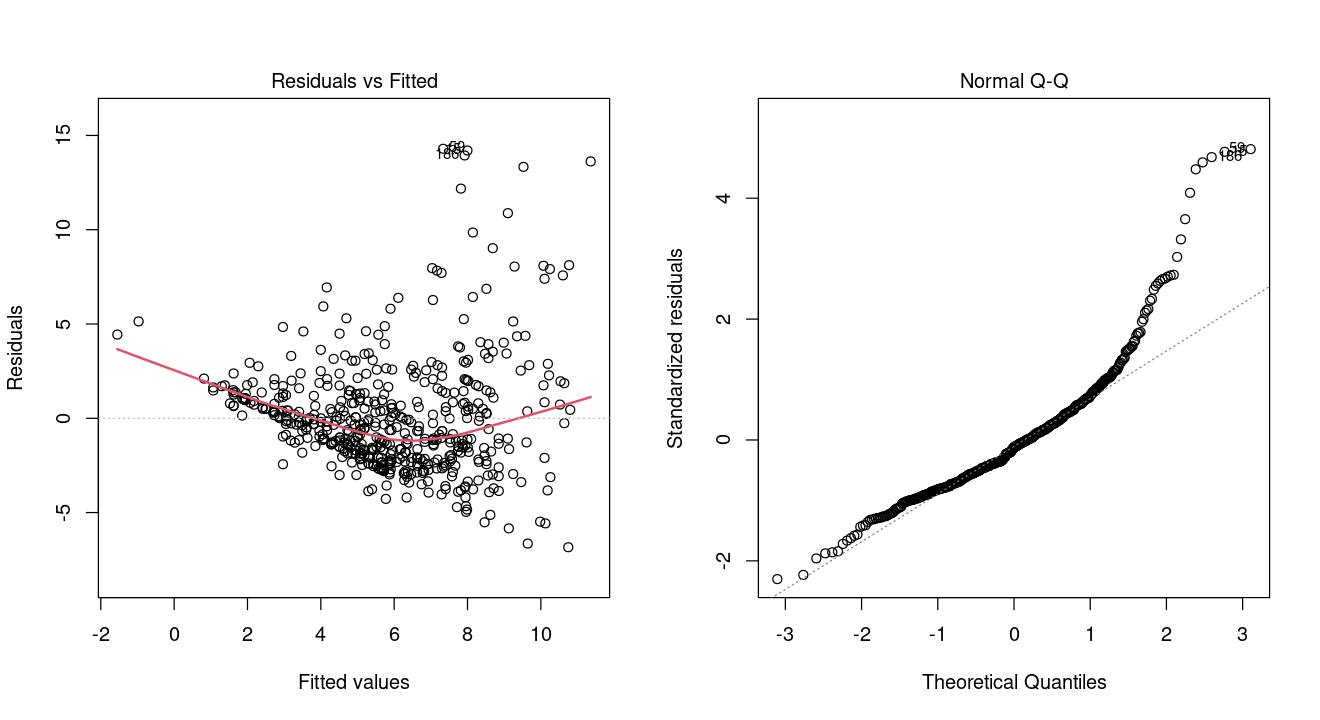

In [57]:
# residual plot
options(repr.plot.width = 11, repr.plot.height = 6)
par(mfrow=c(1,2))
plot(wage_reg4, which=1, lwd=2)
plot(wage_reg4, which=2)

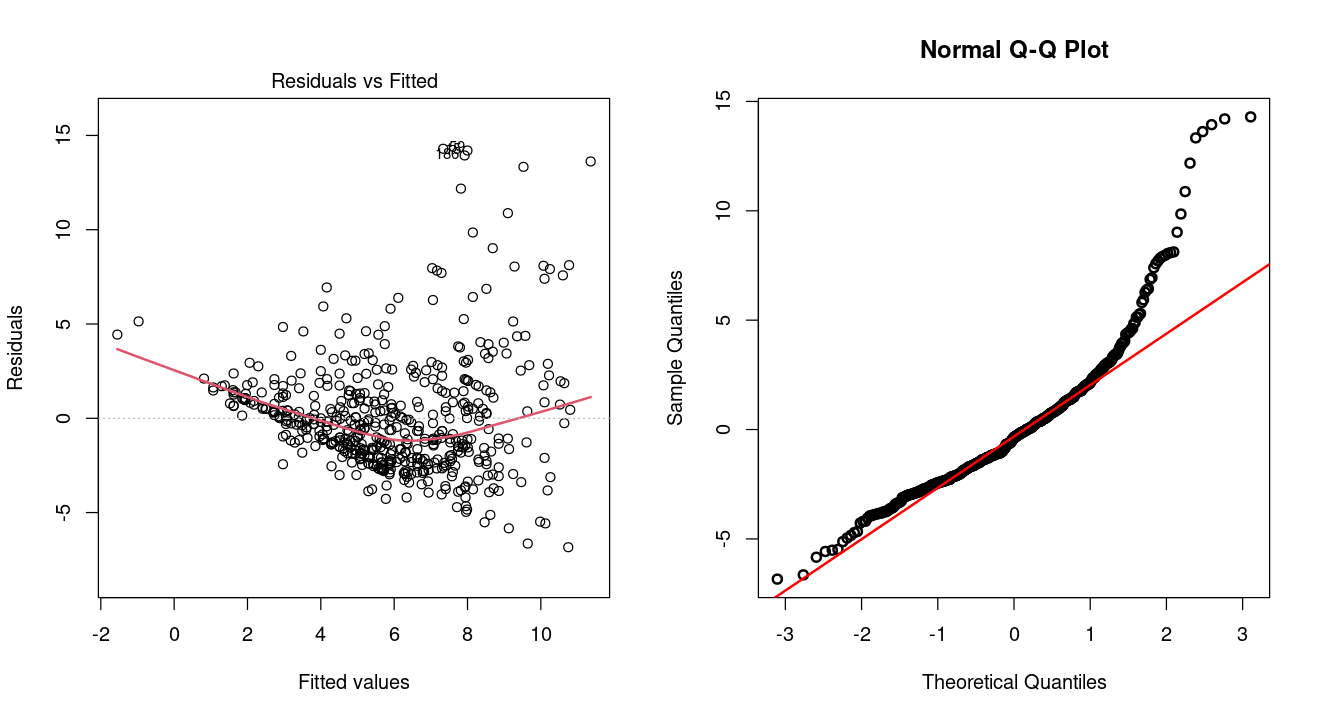

In [58]:
# residual plot
options(repr.plot.width = 11, repr.plot.height = 6)
par(mfrow=c(1,2))
plot(wage_reg4, which=1, lwd=2)
qqnorm(resid(wage_reg4),lwd=2)
qqline(resid(wage_reg4), col='red', lwd=2)

### Log transformation

This only applies to continuous variables (like wage, R&D, etc. for variables like yes/no, female/male)

As we have discussed before, sometimes the dependent variable is not normally distributed.
For instance, the wage is not normally distributed. In this case, we can use log transformation
to make the dependent variable normally distributed. 

The original model is:

$$
wage = \beta_0 + \beta_1 \times educ + \beta_2 \times exper + \beta_3 \times exper^2 + \beta_4  \times female + \epsilon; \quad \epsilon \sim N(0, \sigma^2)
$$

In [59]:
stargazer(wage_reg1, wage_reg2, wage_reg3, wage_reg4, type="text")


                                                          Dependent variable:                                       
                    ------------------------------------------------------------------------------------------------
                                                                  wage                                              
                              (1)                      (2)                     (3)                     (4)          
--------------------------------------------------------------------------------------------------------------------
educ                        0.541***                0.644***                0.595***                0.556***        
                            (0.053)                  (0.054)                 (0.053)                 (0.050)        
                                                                                                                    
exper                                               0.070***   

Now, let's use log transformation on the dependent variable:

$$
\begin{aligned}
wage & = \beta_0 + \beta_1 \times educ + \beta_2 \times exper + \beta_3 \times exper^2 + \beta_4  \times female + \epsilon; \quad \epsilon \sim N(0, \sigma^2) \\
\ln(wage) & = \beta_0 + \beta_1 \times educ + \beta_2 \times exper + \beta_3 \times exper^2 + \beta_4  \times female + \epsilon; \quad \epsilon \sim N(0, \sigma^2)
\end{aligned}
$$

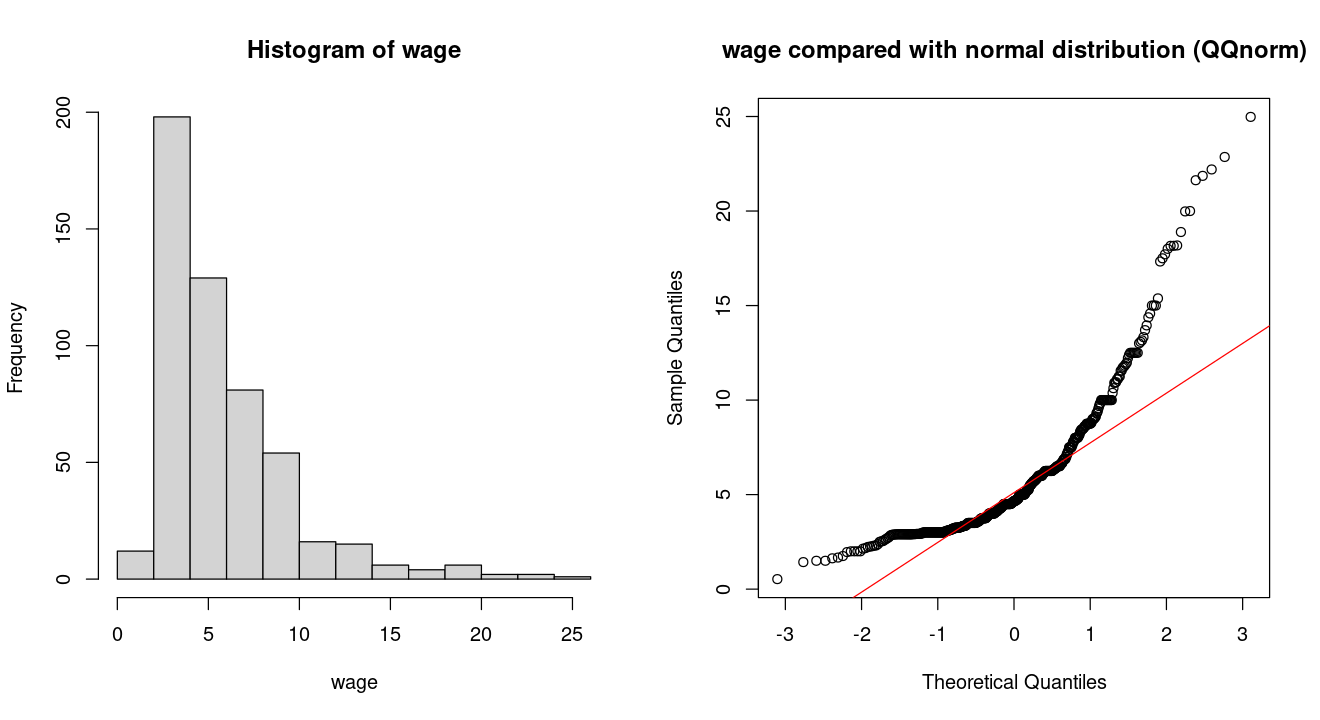

In [27]:
# univariate analysis
options(repr.plot.width = 11, repr.plot.height = 6)
par(mfrow=c(1,2))
wage1 %>%
    with(hist(wage))
qqnorm(wage1$wage, main="wage compared with normal distribution (QQnorm)") 
qqline(wage1$wage, col='red')

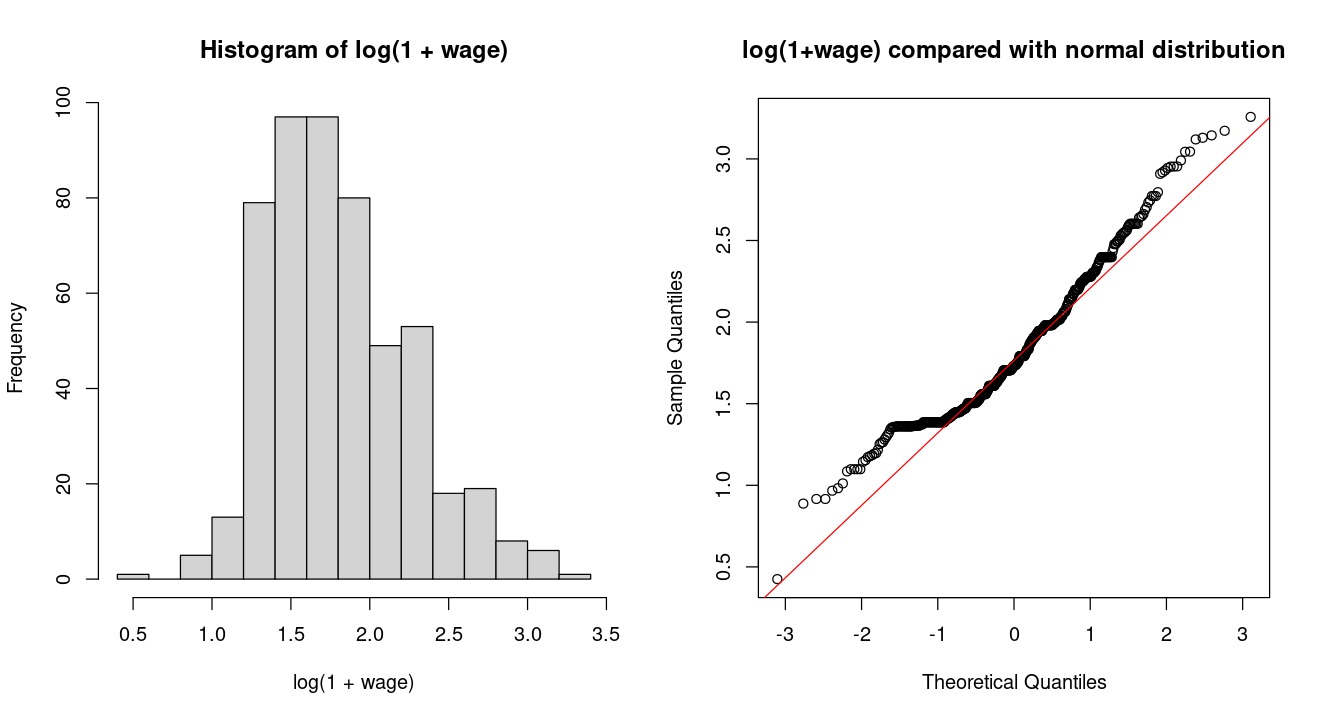

In [28]:
# log transformation for wage (depedent variable)
par(mfrow=c(1,2))
wage1 %>%
    with(hist(log(1+wage))) 
qqnorm(log(1+wage1$wage), main="log(1+wage) compared with normal distribution")
qqline(log(1+wage1$wage), col='red')

Now, we will fit with

$$
\ln(wage) = \beta_0 + \beta_1 \times educ + \beta_2 \times exper + \beta_3 \times exper^2 + \beta_4  \times female + \epsilon; \quad \epsilon \sim N(0, \sigma^2)
$$

In [30]:
# let's fit the model
wage_reg5 <- lm(log(1+wage) ~ educ + exper + I(exper^2) + female, data=wage1) 

stargazer(wage_reg5, type="text")


                        Dependent variable:    
                    ---------------------------
                           log(1 + wage)       
-----------------------------------------------
educ                         0.071***          
                              (0.006)          
                                               
exper                        0.033***          
                              (0.004)          
                                               
I(exper2)                    -0.001***         
                             (0.0001)          
                                               
female                       -0.283***         
                              (0.030)          
                                               
Constant                     0.784***          
                              (0.086)          
                                               
-----------------------------------------------
Observations                    526    

Since we are dealing with log transformation now. The interpretation will be different. The following table 
gives the summary

| | $X$ | $\ln(X)$ |
| --- | --- | --- |
|$Y$| linear: $Y = \beta_0 + \beta_1 X $ | linear-log: $Y=\beta_0 + \beta_1 \ln(X)$ | 
| | one unit change in $X$ is associated with $\beta_1$ change in $Y$ | one unit change in $X$ is associated with $\beta_1/100$ change in $Y$ |
|$\ln(Y)$| log-linear  $\ln(Y) = \beta_0 + \beta_1 X $ | log-log: $\ln(Y) = \beta_0 + \beta_1 \ln(X) $ |
| |one unit change in $X$ is associated with $100 \cdot \beta_1$ percentage change in $Y$  | one percentage change in $X$ is associated with $\beta_1$ percent change in $Y$  |

In [43]:
wage1 %>%
    .[, .(wage, educ, exper, lwage)] %>%
    head()

wage,educ,exper,lwage
<dbl>,<int>,<int>,<dbl>
3.10,11,2,1.131402
3.24,12,22,1.175573
3.00,11,2,1.098612
6.00,8,44,1.791759
5.30,12,7,1.667707
8.75,16,9,2.169054


In [44]:
wage1 %>%
    with(summary(wage))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.530   3.330   4.650   5.896   6.880  24.980 

In [41]:
# suppose my wage is 5.896 dollar per hour
# extra year of education -> 5.896 + 0.556
print(5.896 + 0.556)
# 0.071 * 100 = 7.1 percent 
# extra year of education -> 5.896 * (1 + 0.071)
print(5.896 * (1 + 0.071))

[1] 6.452
[1] 6.314616


In [32]:
# put everything together
stargazer(wage_reg2, wage_reg3, wage_reg4, wage_reg5, type="text")


                                                          Dependent variable:                                      
                    -----------------------------------------------------------------------------------------------
                                                     wage                                        log(1 + wage)     
                              (1)                     (2)                     (3)                     (4)          
-------------------------------------------------------------------------------------------------------------------
educ                       0.644***                0.595***                0.556***                0.071***        
                            (0.054)                 (0.053)                 (0.050)                 (0.006)        
                                                                                                                   
exper                      0.070***                0.268***            

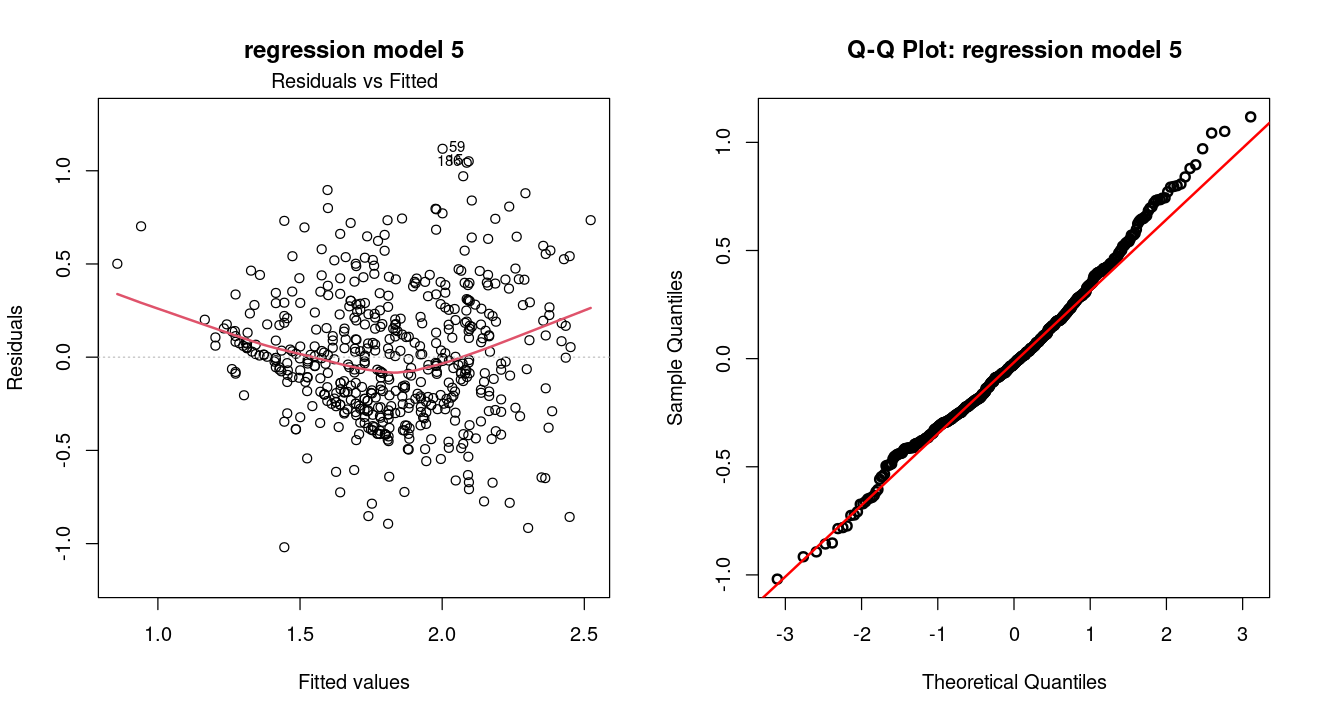

In [77]:
# residual plot for log transformation 
options(repr.plot.width = 11, repr.plot.height = 6)
par(mfrow=c(1,2))
plot(wage_reg5, which=1, lwd=2, main="regression model 5")
qqnorm(resid(wage_reg5),lwd=2, main="Q-Q Plot: regression model 5")
qqline(resid(wage_reg5), col='red', lwd=2)

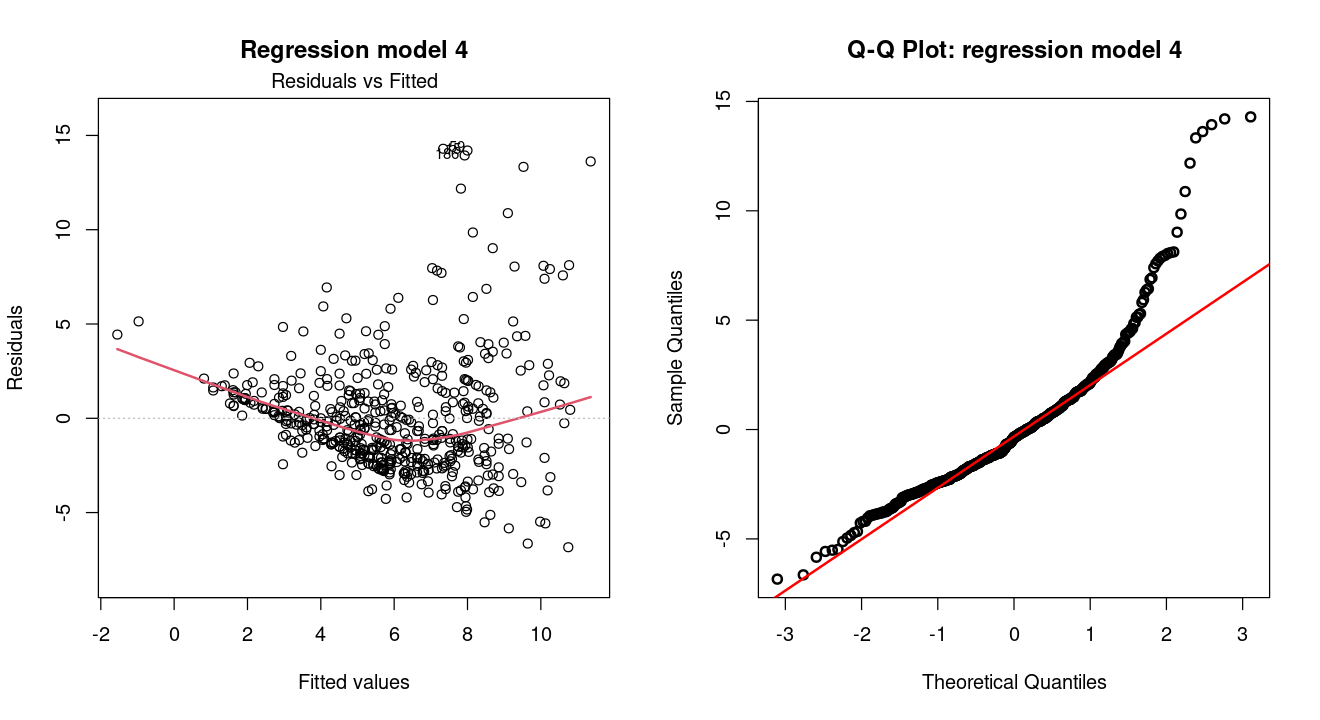

In [79]:
# residual plot without log transformation 
options(repr.plot.width = 11, repr.plot.height = 6)
par(mfrow=c(1,2))
plot(wage_reg4, which=1, lwd=2, main="Regression model 4")
qqnorm(resid(wage_reg4),lwd=2, main="Q-Q Plot: regression model 4")
qqline(resid(wage_reg4), col='red', lwd=2)

### Summary

- why we need control variables
- check whether the coefficient is consistent or not by adding different control variables 
- using dummy variable - gender discrimination 
- why we need log transformation
- how to interpret the log transformation

### The another example

Now, let's use another example to illustrate the regression analysis. The data is about
the relationship between research and development expenditure and the sales.


In [82]:
data(rdchem)
# convert it to data.table
rdchem <- as.data.table(rdchem)
str(rdchem)
head(rdchem)

Classes 'data.table' and 'data.frame':	32 obs. of  8 variables:
 $ rd      : num  430.6 59 23.5 3.5 1.7 ...
 $ sales   : num  4570 2830 597 134 42 ...
 $ profits : num  186.9 467 107.4 -4.3 8 ...
 $ rdintens: num  9.42 2.08 3.94 2.62 4.05 ...
 $ profmarg: num  4.09 16.5 18 -3.22 19.05 ...
 $ salessq : num  20886730 8008900 356170 17849 1764 ...
 $ lsales  : num  8.43 7.95 6.39 4.89 3.74 ...
 $ lrd     : num  6.065 4.078 3.157 1.253 0.531 ...
 - attr(*, "time.stamp")= chr "25 Jun 2011 23:03"
 - attr(*, ".internal.selfref")=<externalptr> 


rd,sales,profits,rdintens,profmarg,salessq,lsales,lrd
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
430.6,4570.2,186.9,9.421906,4.089536,20886730.00,8.427312,6.0651798
59.0,2830.0,467.0,2.084806,16.501766,8008900.00,7.948032,4.0775375
23.5,596.8,107.4,3.937668,17.995979,356170.22,6.391582,3.1570003
3.5,133.6,-4.3,2.619760,-3.218563,17848.96,4.894850,1.2527629
1.7,42.0,8.0,4.047619,19.047619,1764.00,3.737670,0.5306283
8.4,390.0,47.3,2.153846,12.128205,152100.00,5.966147,2.1282318


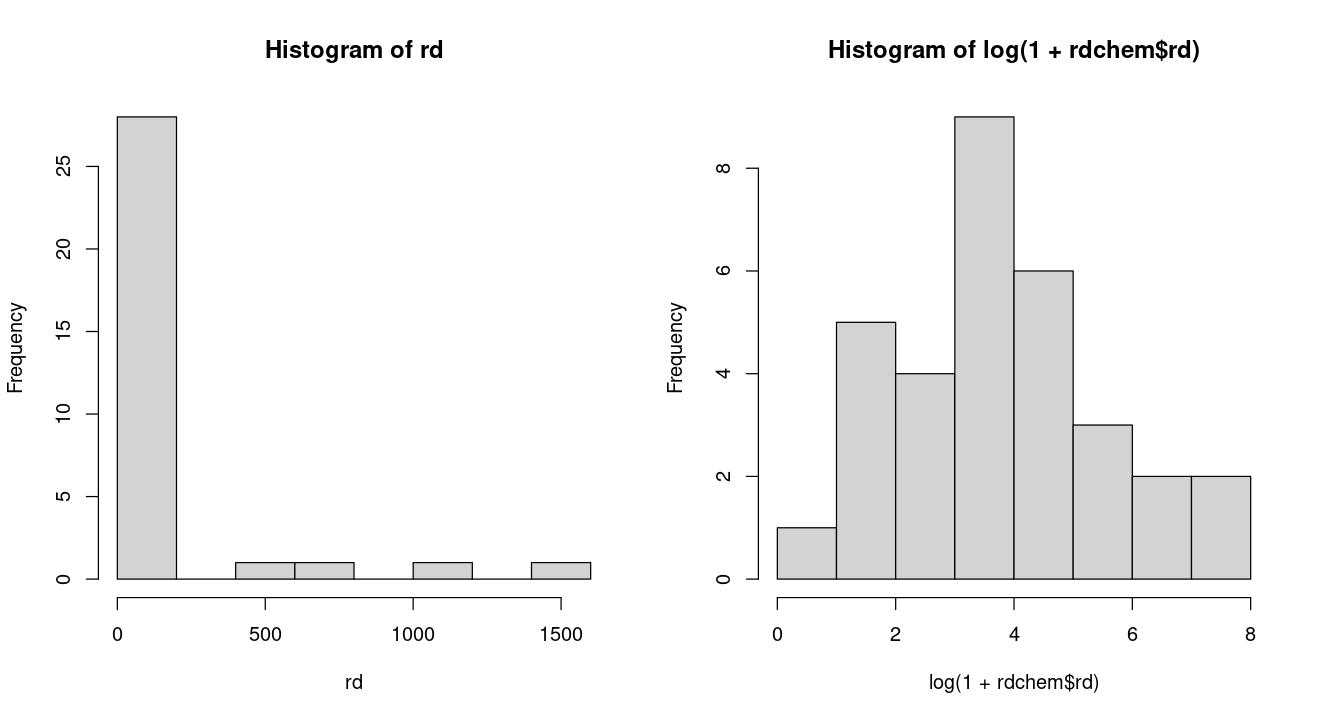

In [90]:
# univariate analysis

par(mfrow=c(1,2))
rdchem %>%
    with(hist(rd))

hist(log(1+rdchem$rd))

We will fit two mdels:

$$
R\&D = \beta_0 + \beta_1 \times sales + \beta_2 \times profitMargin + \epsilon; \quad \epsilon \sim N(0, \sigma^2)
$$

and 

$$
\ln(R\&D) = \beta_0 + \beta_1 \times sales + \beta_2 \times profitMargin + \epsilon; \quad \epsilon \sim N(0, \sigma^2)
$$

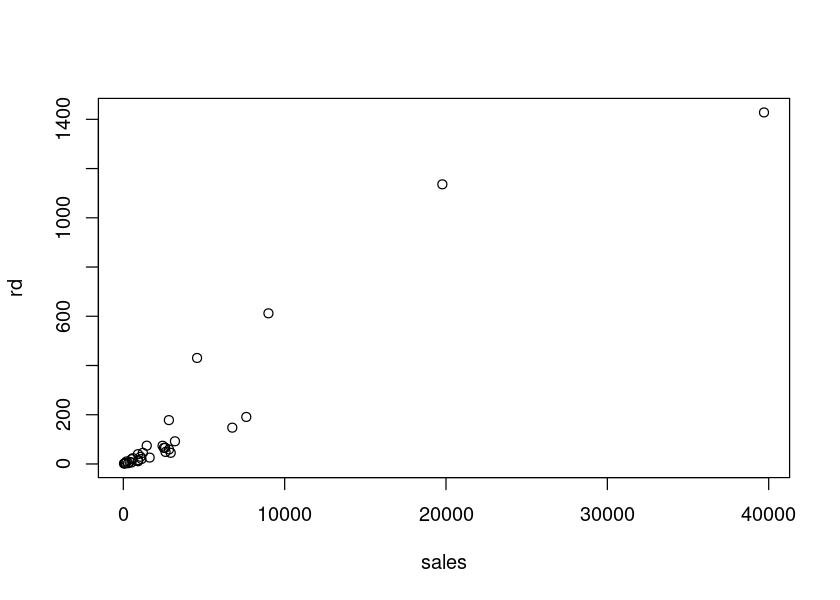

In [98]:
options(repr.plot.width = 7, repr.plot.height = 5)
rdchem %>%
    with(plot(sales, rd))

In [91]:
rd_reg1 <- lm(rd ~ sales + profmarg, data=rdchem)
rd_reg2 <- lm(log(1+rd) ~ sales + profmarg, data=rdchem)

stargazer(rd_reg1, rd_reg2, type="text")


                                  Dependent variable:     
                              ----------------------------
                                    rd        log(1 + rd) 
                                   (1)            (2)     
----------------------------------------------------------
sales                            0.041***      0.0002***  
                                 (0.002)       (0.00003)  
                                                          
profmarg                          0.857          0.003    
                                 (2.605)        (0.030)   
                                                          
Constant                          -9.013       3.076***   
                                 (33.025)       (0.380)   
                                                          
----------------------------------------------------------
Observations                        32            32      
R2                                0.902          0.495 

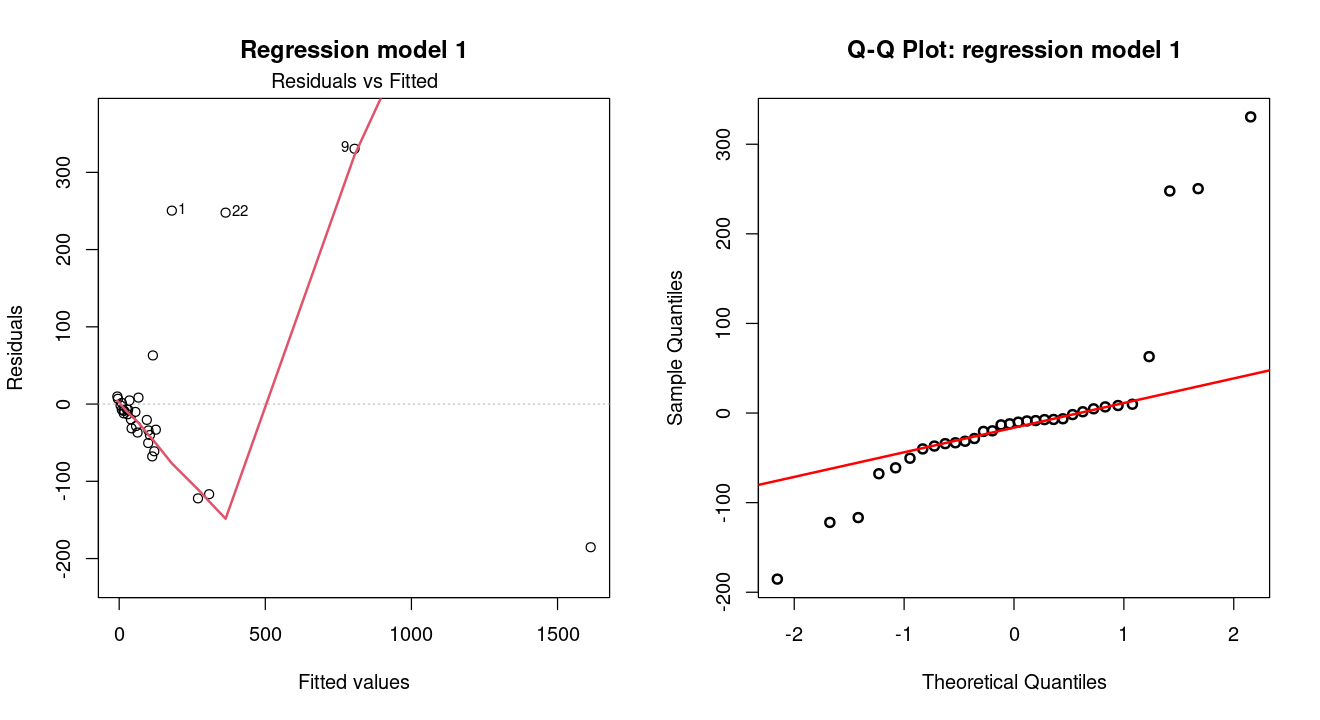

In [92]:
# check residual plot
options(repr.plot.width = 11, repr.plot.height = 6)
par(mfrow=c(1,2))
plot(rd_reg1, which=1, lwd=2, main="Regression model 1")
qqnorm(resid(rd_reg1),lwd=2, main="Q-Q Plot: regression model 1")
qqline(resid(rd_reg1), col='red', lwd=2)

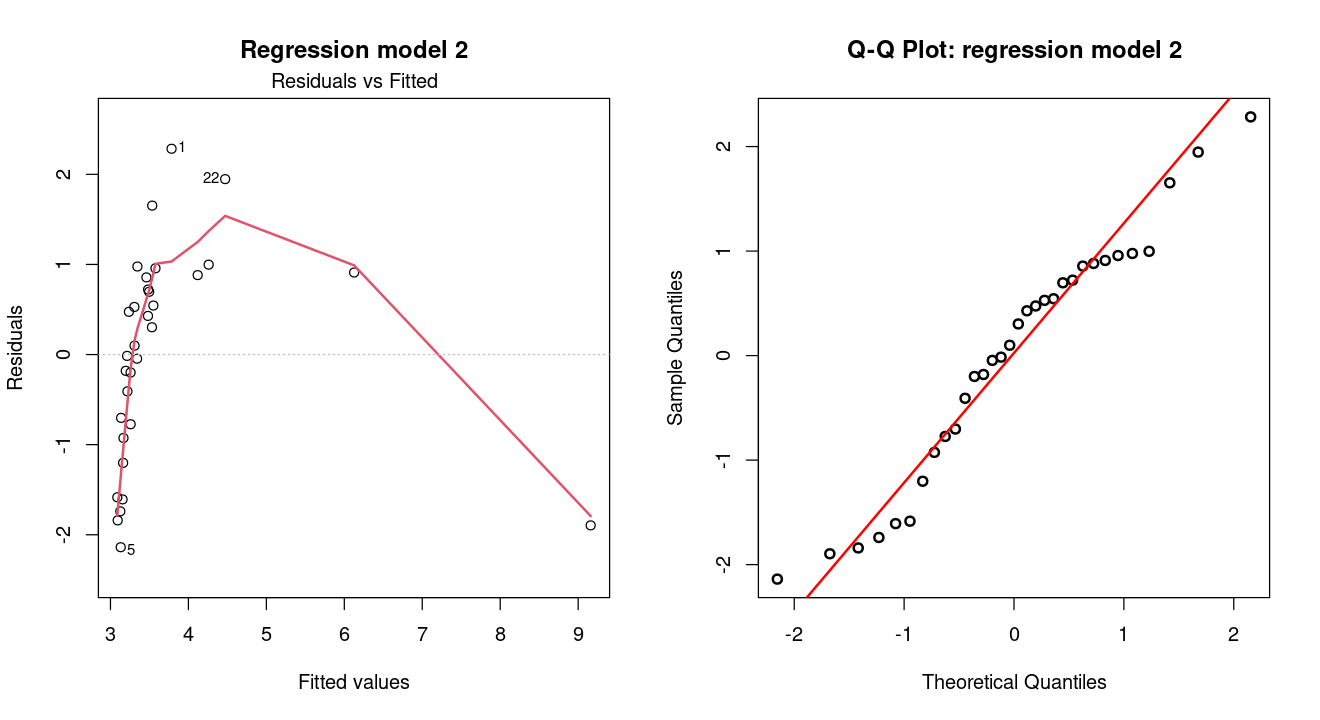

In [95]:
options(repr.plot.width = 11, repr.plot.height = 6)
par(mfrow=c(1,2))
plot(rd_reg2, which=1, lwd=2, main="Regression model 2")
qqnorm(resid(rd_reg2),lwd=2, main="Q-Q Plot: regression model 2")
qqline(resid(rd_reg2), col='red', lwd=2)

### Multicollienarity

Multicollienarity is a very important concept in regression analysis. It means that there is a strong correlation between two or more independent variables. For instance, if we have two independent variables, $X_1$ and $X_2$, and they are strongly correlated, then we say there is a multicollinearity in the model.

This will cause the following problems:

- it increases the variance of the coefficients and makes the coefficients less reliable.
- it makes the interpretation of the coefficients difficult.


We will simulate a dataset to illustrate the problem of multicollinearity.

We have simulated the relationship between `weight` and `height` as follows:

$$
weight = \beta_0 + \beta_1 \times height + \epsilon; \quad \epsilon \sim N(0, \sigma^2)
$$

![hand-span](https://milkatcarmel.files.wordpress.com/2016/10/hand-span-photo.jpg)


Now, let's add another variable called `handspan` to the model. The `handspan` is strongly correlated with `height`. On average, human's handspan is about 5% to 6% of the height. For instance, if the height is 170cm, then the handspan is about 9 cm. Therefore, we can simulate the `handspan` as follows:

$$
handspan =  0.3 + 0.05 \times height + \epsilon; \quad \epsilon \sim N(0, \sigma^2)
$$

At the same time, we assume that the `weight` is related to `height` as follows:

$$
weight = 55 + 0.1 * height + \epsilon; \quad \epsilon \sim N(0, 2)
$$

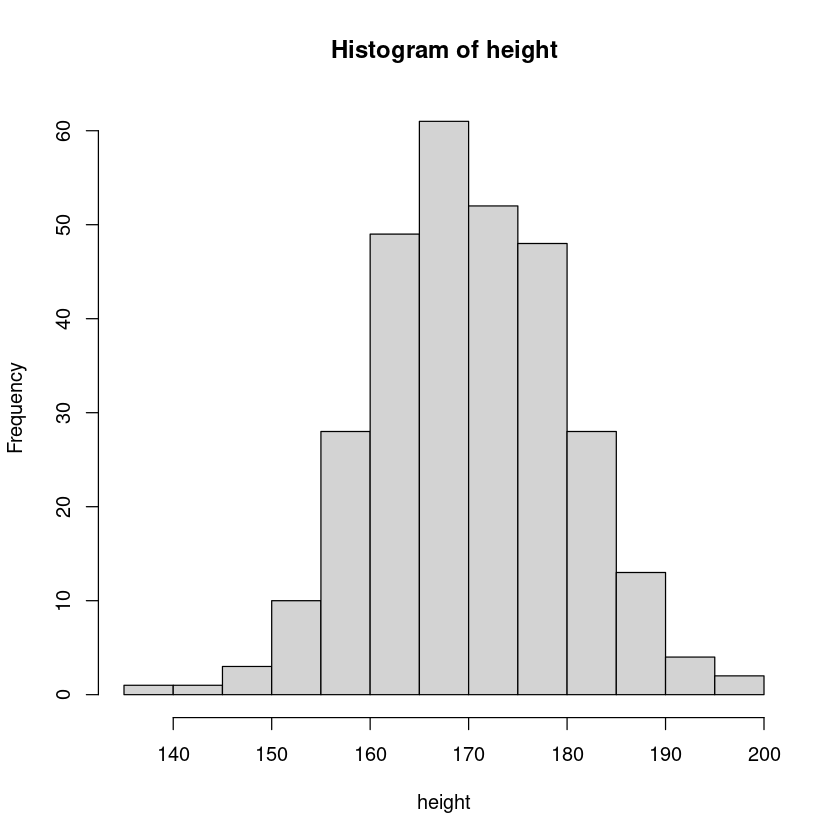

In [3]:
# generate height data with 300 observations mean = 170, sd = 10
height <- rnorm(300, 170, 10)
hist(height)

In [4]:
# generate handspan data
handspan <- 0.3 + 0.05 * height + rnorm(300, 0, 0.5)
# generate weight data
weight <- 55 + 0.1 * height + rnorm(300, 0, 2)

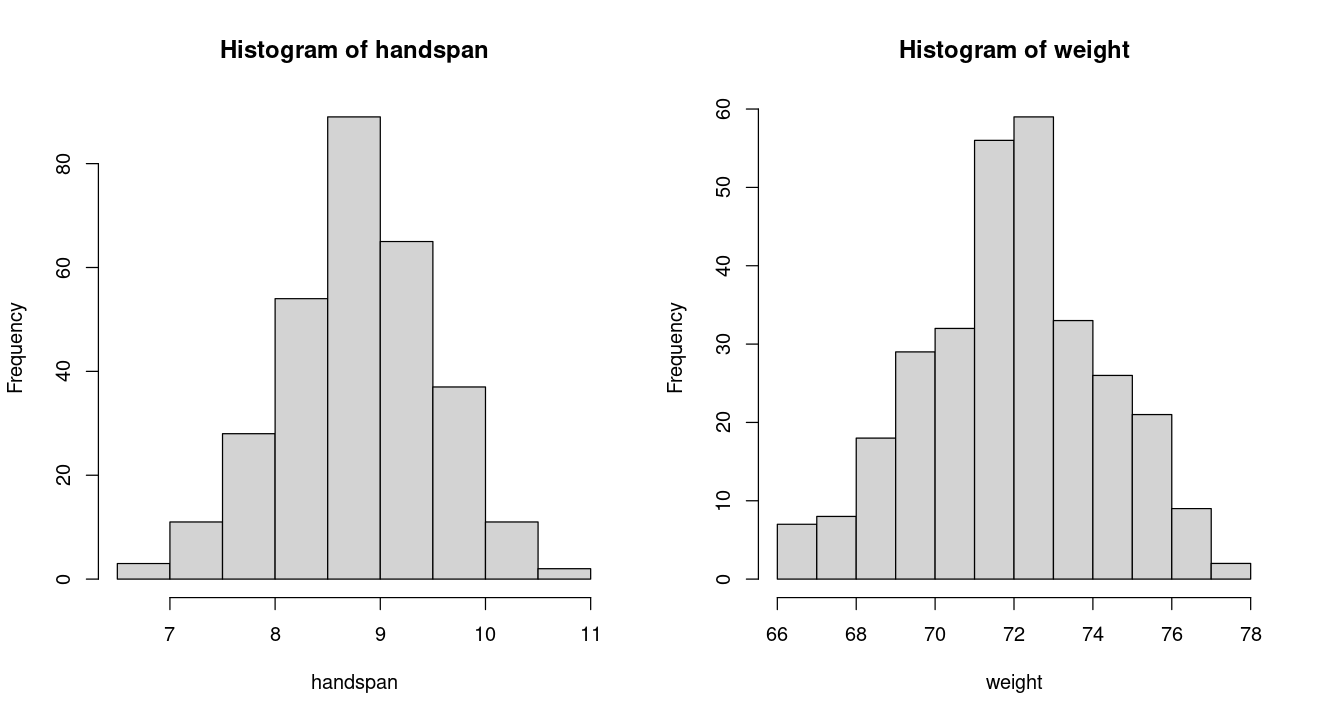

In [13]:
options(repr.plot.width = 11, repr.plot.height = 6)
par(mfrow=c(1,2))
hist(handspan)
hist(weight)

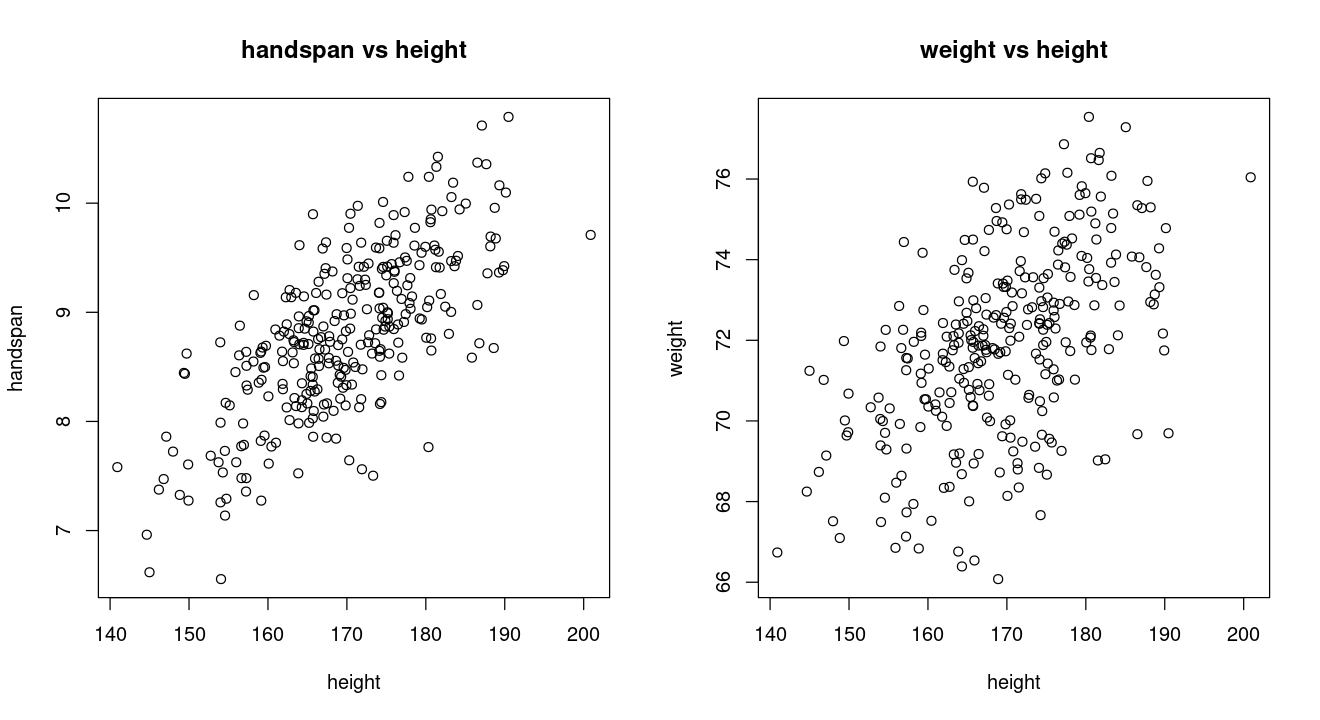

In [15]:
par(mfrow=c(1,2))
plot(height, handspan, main="handspan vs height")
plot(height, weight, main="weight vs height")

In [5]:
# put everything together
hhw_data <- data.table(height, handspan, weight)
head(hhw_data)

height,handspan,weight
<dbl>,<dbl>,<dbl>
160.6313,9.437543,71.96926
168.8993,8.059166,73.24850
174.9326,9.258373,71.37237
187.1010,9.322314,77.28160
159.9146,7.871816,73.86087
167.6257,10.042967,70.58966


In [19]:
# check correlation
hhw_data %>%
    with(cor(height, handspan))

[1] 0.7126107

Now, let's fit with two models:

$$
weight = \beta_0 + \beta_1 \cdot height  + \epsilon; \quad \epsilon \sim N(0, \sigma^2)
$$

and 

$$
weight = \beta_0 + \beta_1 \cdot height + \beta_2 \cdot handspan + \epsilon; \quad \epsilon \sim N(0, \sigma^2)
$$


In [6]:
hhw_reg1 <- lm(weight ~ height, data=hhw_data)
hhw_reg2 <- lm(weight ~ height + handspan, data=hhw_data)
hhw_reg3 <- lm(weight ~ handspan, data=hhw_data)

stargazer(hhw_reg1, hhw_reg2, hhw_reg3, type="text")


                                              Dependent variable:                          
                    -----------------------------------------------------------------------
                                                    weight                                 
                              (1)                     (2)                     (3)          
-------------------------------------------------------------------------------------------
height                     0.113***                0.122***                                
                            (0.012)                 (0.017)                                
                                                                                           
handspan                                            -0.180                 1.051***        
                                                    (0.235)                 (0.179)        
                                                                               

In [8]:
install.packages("performance")
install.packages("see")
install.packages("patchwork")


Installing package into '/usr/local/lib/R/site-library'
(as 'lib' is unspecified)

also installing the dependencies 'bayestestR', 'insight', 'datawizard'




In [ ]:
library("performance")

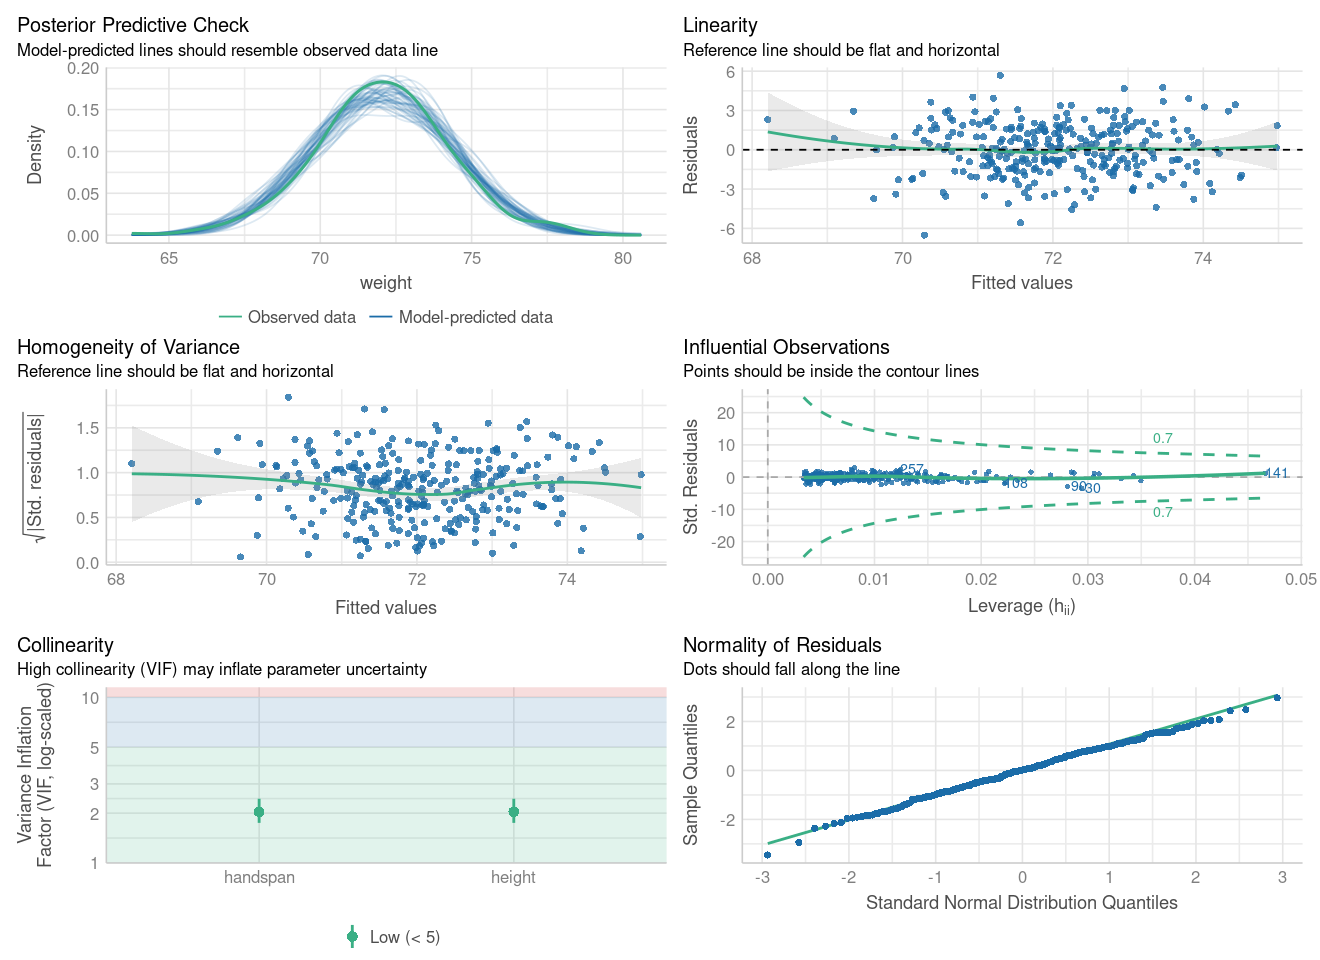

In [16]:
# test for multicollinearity
options(repr.plot.width = 11, repr.plot.height = 8)
check_model(hhw_reg2)

In [2]:
# another example
elem_data <- fread("https://shorturl.at/awLNT")
head(elem_data)

snum,dnum,api00,api99,growth,meals,ell,yr_rnd,mobility,acs_k3,⋯,hsg,some_col,col_grad,grad_sch,avg_ed,full,emer,enroll,mealcat,collcat
<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<dbl>,<int>,<int>,<int>,<int>,<int>
906,41,693,600,93,67,9,0,11,16,⋯,0,0,0,0,NA,76,24,247,2,1
889,41,570,501,69,92,21,0,33,15,⋯,0,0,0,0,NA,79,19,463,3,1
887,41,546,472,74,97,29,0,36,17,⋯,0,0,0,0,NA,68,29,395,3,1
876,41,571,487,84,90,27,0,27,20,⋯,45,9,9,0,1.91,87,11,418,3,1
888,41,478,425,53,89,30,0,44,18,⋯,50,0,0,0,1.50,87,13,520,3,1
4284,98,858,844,14,10,3,0,10,20,⋯,8,24,36,31,3.89,100,0,343,1,2


In [3]:
str(elem_data)

Classes ‘data.table’ and 'data.frame':	400 obs. of  22 variables:
 $ snum    : int  906 889 887 876 888 4284 4271 2910 2899 2887 ...
 $ dnum    : int  41 41 41 41 41 98 98 108 108 108 ...
 $ api00   : int  693 570 546 571 478 858 918 831 860 737 ...
 $ api99   : int  600 501 472 487 425 844 864 791 838 703 ...
 $ growth  : int  93 69 74 84 53 14 54 40 22 34 ...
 $ meals   : int  67 92 97 90 89 10 5 2 5 29 ...
 $ ell     : int  9 21 29 27 30 3 2 3 6 15 ...
 $ yr_rnd  : int  0 0 0 0 0 0 0 0 0 0 ...
 $ mobility: int  11 33 36 27 44 10 16 44 10 17 ...
 $ acs_k3  : int  16 15 17 20 18 20 19 20 20 21 ...
 $ acs_46  : int  22 32 25 30 31 33 28 31 30 29 ...
 $ not_hsg : int  0 0 0 36 50 1 1 0 2 8 ...
 $ hsg     : int  0 0 0 45 50 8 4 4 9 25 ...
 $ some_col: int  0 0 0 9 0 24 18 16 15 34 ...
 $ col_grad: int  0 0 0 9 0 36 34 50 42 27 ...
 $ grad_sch: int  0 0 0 0 0 31 43 30 33 7 ...
 $ avg_ed  : num  NA NA NA 1.91 1.5 ...
 $ full    : int  76 79 68 87 87 100 100 96 100 96 ...
 $ emer    : int  

- `api00` : grade API score in 2000
- `acs_k3`: average class size 
- `avg_ed`: average education degree of parents
- `grad_sch`: parent graduation school 
- `col_grad`: parent colledge degree
- `some_col`: parent some college

In [4]:
elem_data %>%
    .[, .(api00, acs_k3, avg_ed, grad_sch, col_grad, some_col)] %>%
    head()

api00,acs_k3,avg_ed,grad_sch,col_grad,some_col
<int>,<int>,<dbl>,<int>,<int>,<int>
693,16,NA,0,0,0
570,15,NA,0,0,0
546,17,NA,0,0,0
571,20,1.91,0,9,9
478,18,1.50,0,0,0
858,20,3.89,31,36,24


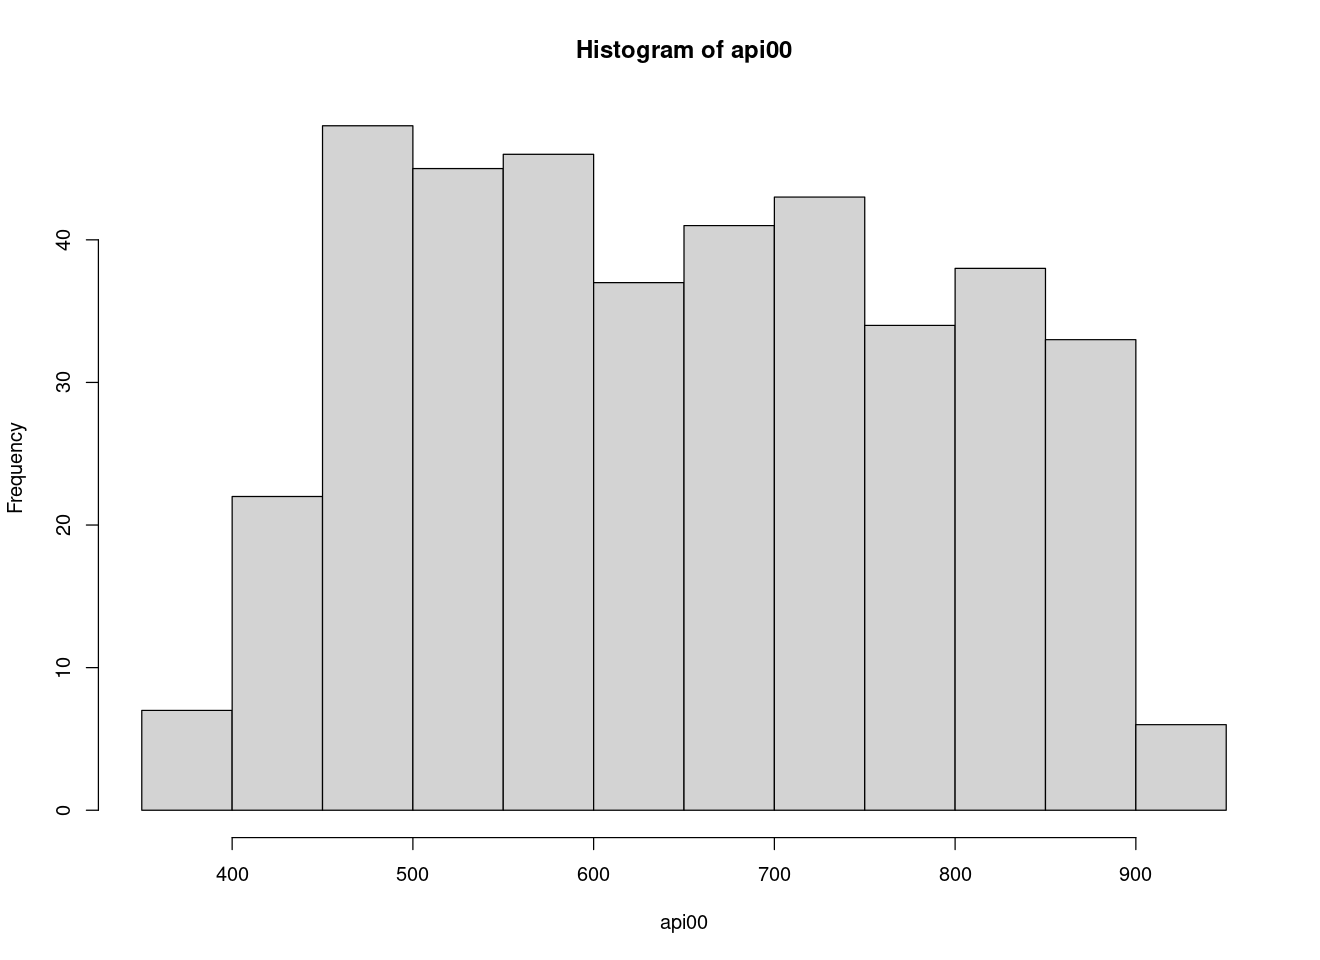

In [12]:
elem_data %>%
    .[, .(api00, acs_k3, avg_ed, grad_sch, col_grad, some_col)] %>%
    with(hist(api00))

Now I want to exam:

$$
grade_{api00} = \beta_0 + \beta_1 acsK3 + \beta_2 avgEd + \beta_3 gradSch + \beta_4 colGrad + \beta_5 someCol + \epsilon ; \quad \epsilon \sim N(0, \sigma^2)
$$


In [9]:
elem_data <- fread("https://shorturl.at/awLNT")
elem_reg1 <- lm(api00 ~ acs_k3 + avg_ed +  grad_sch + col_grad + some_col, data = elem_data)
stargazer(elem_reg1, type='text')


                        Dependent variable:    
                    ---------------------------
                               api00           
-----------------------------------------------
acs_k3                       11.457***         
                              (3.275)          
                                               
avg_ed                      227.264***         
                             (37.220)          
                                               
grad_sch                      -2.091           
                              (1.352)          
                                               
col_grad                     -2.968***         
                              (1.018)          
                                               
some_col                      -0.760           
                              (0.811)          
                                               
Constant                      -82.609          
                             (81.846)  

In [ ]:
install.packages("performance")
install.packages("see")
install.packages("patchwork")

In [10]:
library(performance)

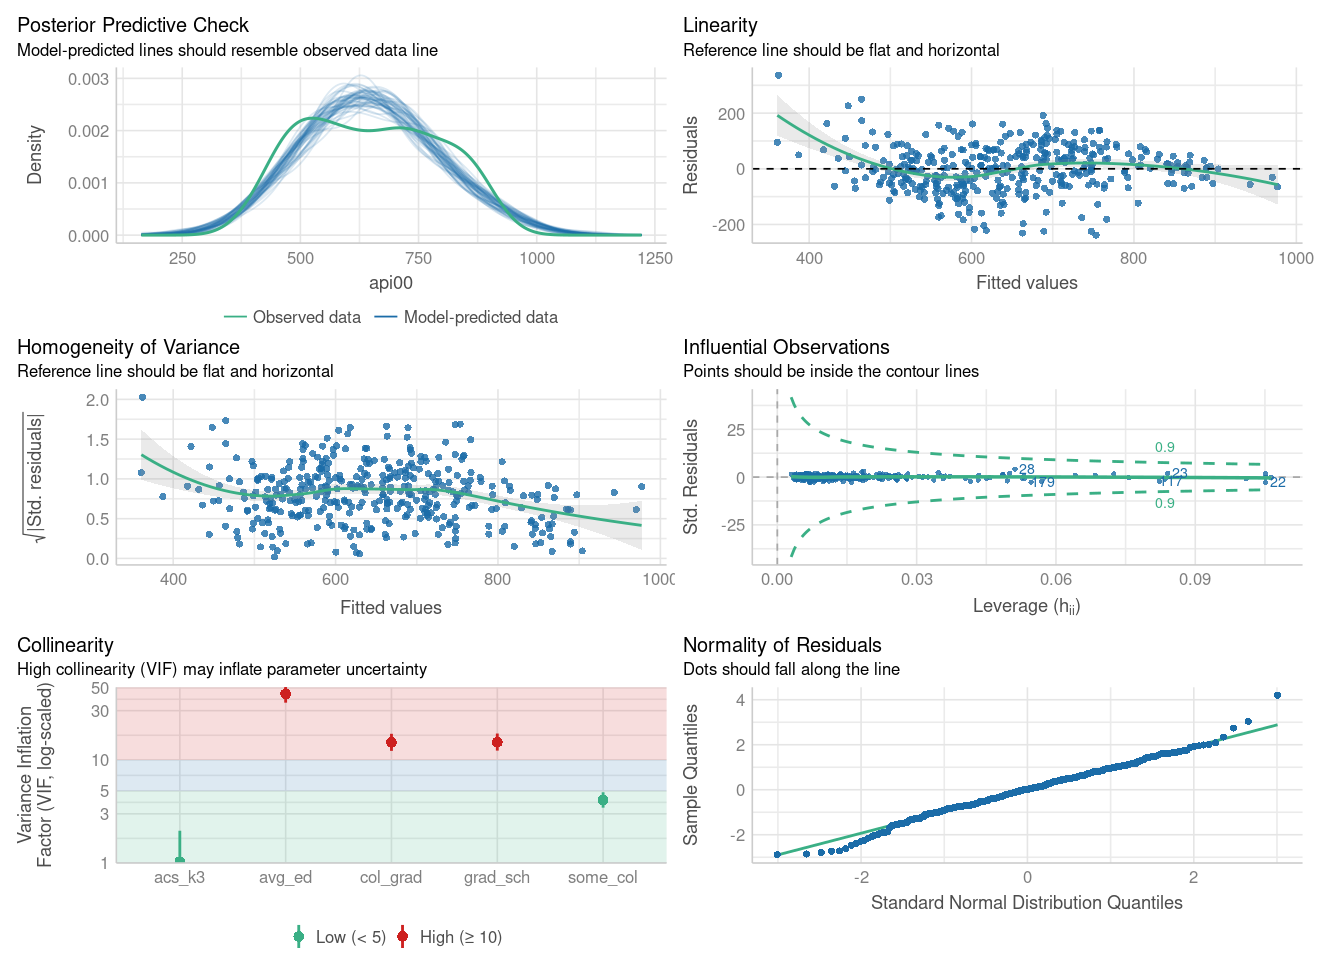

In [11]:
options(repr.plot.width = 11, repr.plot.height = 8)
check_model(elem_reg1)

__Summary__



| Assumptions|Diagnostic check|
|:---------| ---------------|
A1: linear relationship between $y$ and $x$| check via plots |
A2: independence of observations | check via plots |
A3: $E(\epsilon |x) = 0$ | check via plots |
A4: $Var(\epsilon |x) = \sigma^2 $ | check via plots|
A5: normal distribution of $\epsilon \sim N(0, \sigma^2)$ | check via plots |
A6: No correlation between $x$ and $\epsilon$ | check via plots |

### High influential points

In [ ]:
install.packages("wooldridge")

In [13]:
library(wooldridge)
data("infmrt")
str(infmrt)


Attaching package: ‘wooldridge’


The following object is masked from ‘package:MASS’:

    cement




'data.frame':	102 obs. of  12 variables:
 $ year   : int  1987 1990 1987 1990 1987 1990 1987 1990 1987 1990 ...
 $ infmort: num  8.3 6.2 7.8 7.1 8.5 ...
 $ afdcprt: int  52 62 11 21 20 25 234 282 42 52 ...
 $ popul  : int  1186 1228 1056 1109 547 563 5856 6016 986 1003 ...
 $ pcinc  : int  13996 17125 18083 21051 14267 17630 19131 22558 15683 18771 ...
 $ physic : int  173 178 186 200 244 253 322 337 244 254 ...
 $ afdcper: num  4.38 5.05 1.04 1.89 3.66 ...
 $ d90    : int  0 1 0 1 0 1 0 1 0 1 ...
 $ lpcinc : num  9.55 9.75 9.8 9.95 9.57 ...
 $ lphysic: num  5.15 5.18 5.23 5.3 5.5 ...
 $ DC     : int  0 0 0 0 0 0 0 0 0 0 ...
 $ lpopul : num  7.08 7.11 6.96 7.01 6.3 ...
 - attr(*, "time.stamp")= chr "25 Jun 2011 23:03"


In [25]:
infmrt <- as.data.table(infmrt)
infmrt %>%
    .[lphysic <= 6.0] %>%
    .[, .(infmort, lpcinc, lphysic, lpopul)] -> infmrt2 

head(infmrt2)

infmort,lpcinc,lphysic,lpopul
<dbl>,<dbl>,<dbl>,<dbl>
8.3,9.546527,5.153292,7.078341
6.2,9.748295,5.181784,7.113142
7.8,9.802728,5.225747,6.962244
7.1,9.954703,5.298317,7.011214
8.5,9.565704,5.497168,6.304449
6.4,9.777357,5.533390,6.333280


In [30]:
infmrt_reg1 <- lm(infmort ~ lpcinc + lphysic + lpopul, data = infmrt)
stargazer(infmrt_reg1, type="text")


                        Dependent variable:    
                    ---------------------------
                              infmort          
-----------------------------------------------
lpcinc                       -4.884***         
                              (1.293)          
                                               
lphysic                      4.028***          
                              (0.891)          
                                               
lpopul                        -0.054           
                              (0.187)          
                                               
Constant                     36.226***         
                             (10.135)          
                                               
-----------------------------------------------
Observations                    102            
R2                             0.182           
Adjusted R2                    0.157           
Residual Std. Error       1.891 (df = 9

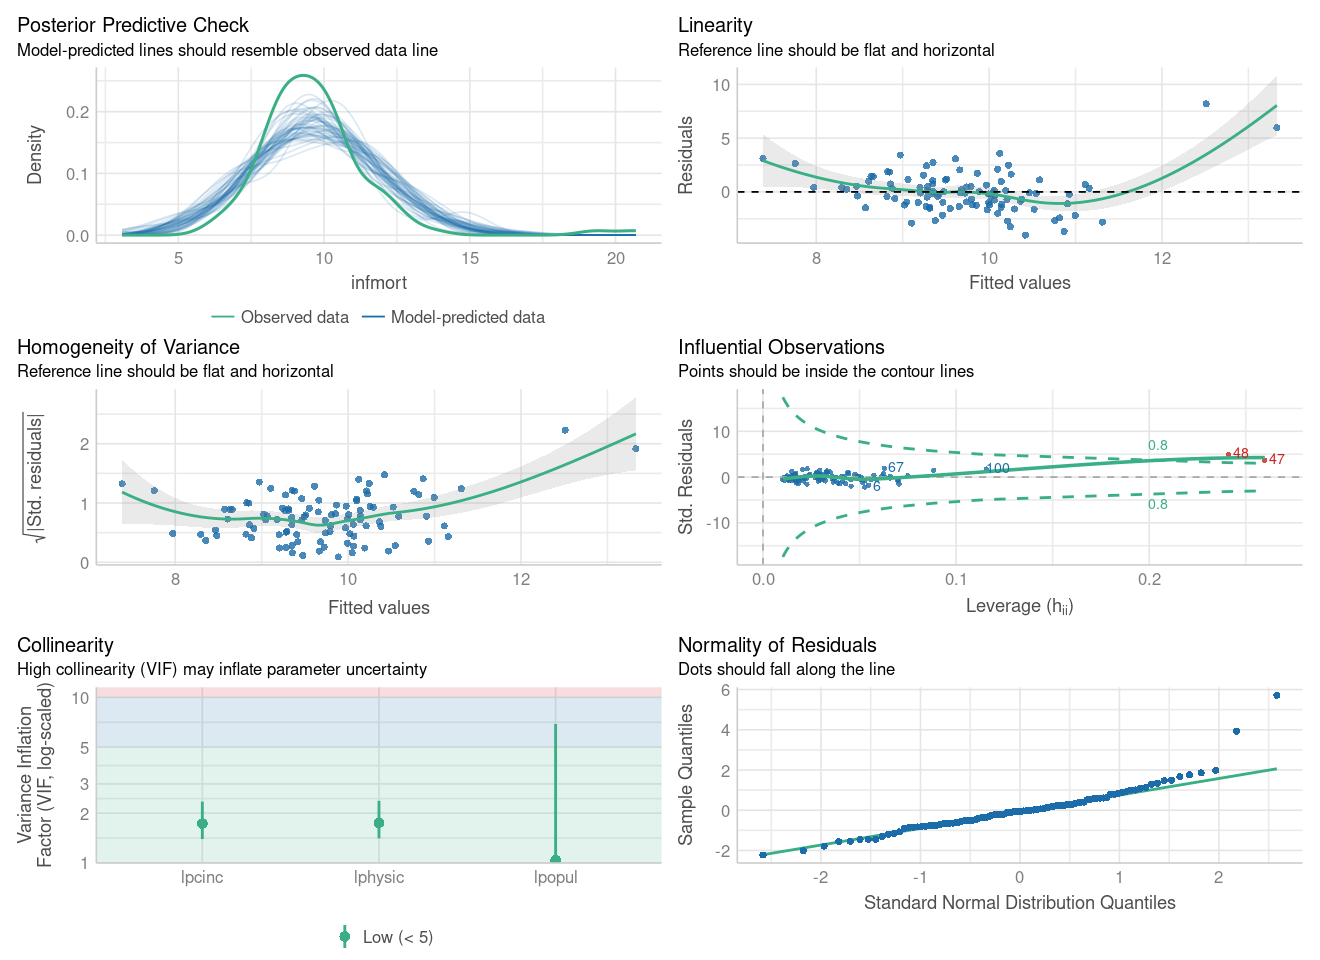

In [31]:
check_model(infmrt_reg1)

In [34]:
infmrt_reg2 <- lm(infmort ~ lpcinc + lphysic + lpopul, data = infmrt2)
stargazer(infmrt_reg2, type="text")


                        Dependent variable:    
                    ---------------------------
                              infmort          
-----------------------------------------------
lpcinc                       -2.484***         
                              (0.889)          
                                               
lphysic                       -1.516*          
                              (0.773)          
                                               
lpopul                       0.576***          
                              (0.136)          
                                               
Constant                     36.854***         
                              (6.744)          
                                               
-----------------------------------------------
Observations                    100            
R2                             0.286           
Adjusted R2                    0.264           
Residual Std. Error       1.254 (df = 9

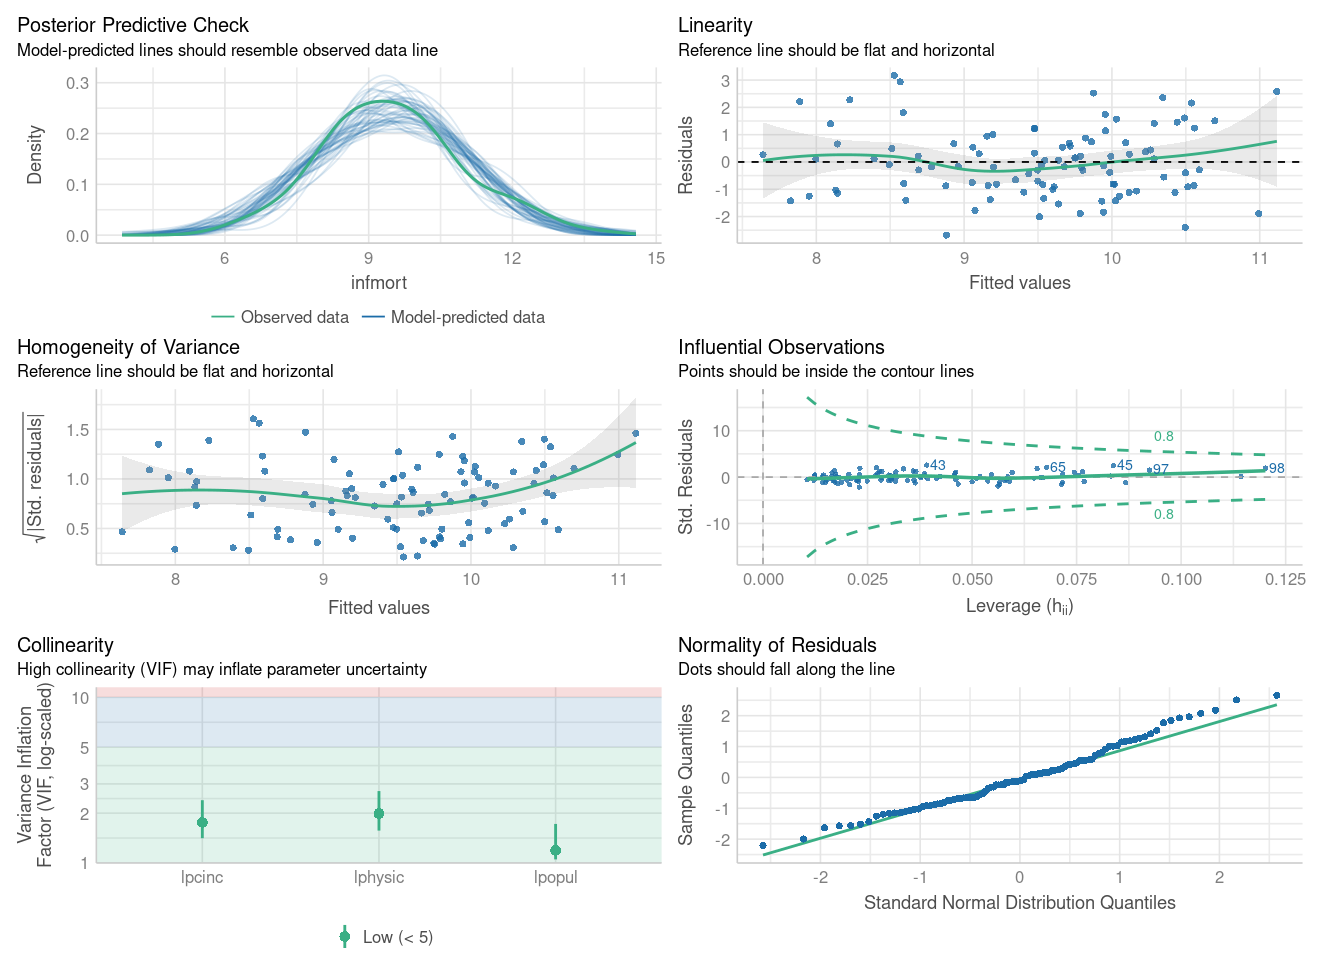

In [33]:
check_model(infmrt_reg2)

### Regression Analysis with CIS data

Now, we will learn how to use regression analysis to analyze the relationship between
innovation intensity and other variables. Here we are setting up a simple linear regression
meaning:

- dependent variable: innovation intensity (`ias`)
- independent variable: marketing intensity (`markets`), `softws`, `designs`, `wbp`, `fues`, `inv`
, etc. 


Let's start from the simplest model: `ias` and `invs`, our hypothesis is that __there is a
positive relationship between investment and innovation intensity__. We will use `lm` function to do the regression analysis.
If we write down the regression equation, it will be:

$$
ias = \beta_0 + \beta_1 invs + \epsilon; \quad \epsilon \sim N(0, \sigma^2)
$$

Here we assume that the error term is normally distributed with mean 0 and variance $\sigma^2$.


In [36]:
# simple regression 
model1 <- lm(ias ~ invs, data = cis2)

# check summary
summary(model1)


Call:
lm(formula = ias ~ invs, data = cis2)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.11102 -0.03781 -0.03643  0.00083  1.11829 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 0.037262   0.003421  10.892   <2e-16 ***
invs        0.073755   0.036212   2.037    0.042 *  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.08951 on 788 degrees of freedom
  (252 observations deleted due to missingness)
Multiple R-squared:  0.005237,	Adjusted R-squared:  0.003974 
F-statistic: 4.148 on 1 and 788 DF,  p-value: 0.04201


In [37]:
# print out coefficients
stargazer(model1, type = "text")


                        Dependent variable:    
                    ---------------------------
                                ias            
-----------------------------------------------
invs                          0.074**          
                              (0.036)          
                                               
Constant                     0.037***          
                              (0.003)          
                                               
-----------------------------------------------
Observations                    790            
R2                             0.005           
Adjusted R2                    0.004           
Residual Std. Error      0.090 (df = 788)      
F Statistic            4.148** (df = 1; 788)   
Note:               *p<0.1; **p<0.05; ***p<0.01


Based on the above regression result, we can see that the coefficient of `invs` is 0.074,
which is significantly different from 0. This means that there is a positive relationship
between `invs` and `ias`. Therefore we cannot reject our hypothesis.

If you set our null hypothesis as __there is no relationship between `invs` and `ias`__,
then our alternative hypothesis is __there is a relationship between `invs` and `ias`__.
Then, we can use the above regression result to reject the null hypothesis.

The above regression is very simple as we only have one independent variable. This means
we did not control other variables. In real life, we need to control other variables.
For instance, the relationship between `ias` and `invs` could be affected by other variables,
such as industry, firm size, etc. So, we need to control those variables.

What does control mean? It means that we need to include those variables in the regression
model. For instance, we can include `bges` (firm size) in the regression model. The regression
equation will be:

$$
ias = \beta_0 + \beta_1 invs + \beta_2 bges + \epsilon; \quad \epsilon \sim N(0, \sigma^2)
$$

Visually, controlling means that we will investigate the relationship between `ias` and `invs`
by fixing the other variables, such as industry. The following graph shows the relationship
of `ias` and `invs` for different industries.

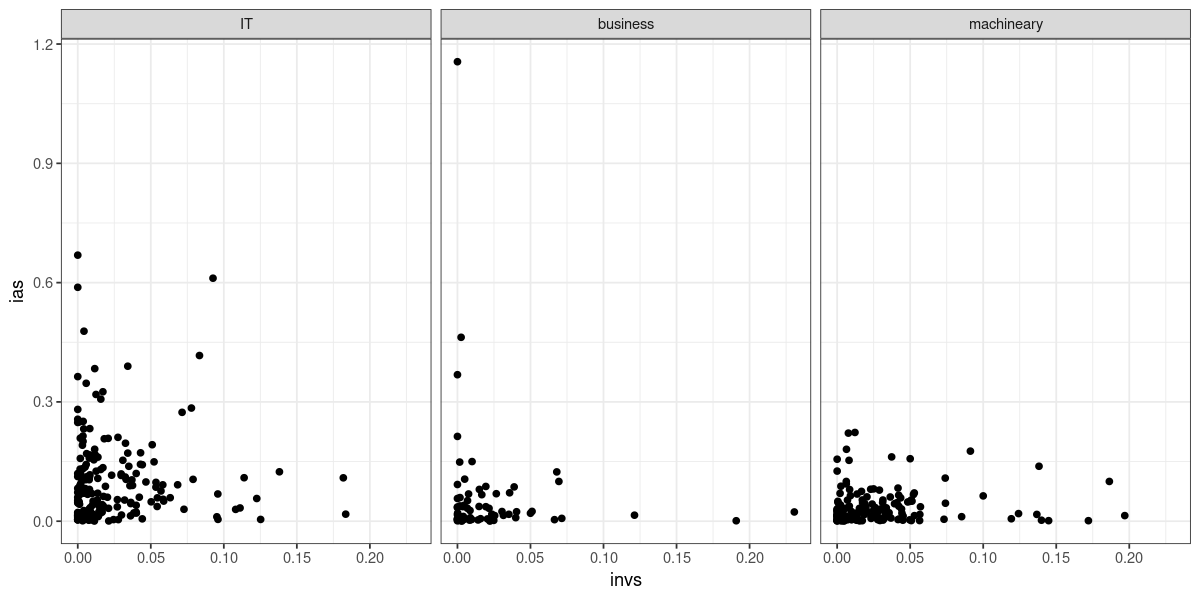

In [52]:
# plot relationship between ias and invs cross industry
options(repr.plot.width = 10, repr.plot.height = 5)
cis2 %>%
    .[ias > 0 & invs < 0.25] %>%
    .[, .(ias, invs, industry)] %>%
    ggplot(aes(x = invs, y = ias)) +
    geom_point() + 
    facet_wrap(~industry, nrow = 1) +
    theme_bw()

As you can see that the relationship between `ias` and `invs` is different for different
industries. For instance, for the industry 1, the relationship is positive. However, for
business industry the relationship is not very clear. 

Now, let's run the regression model with industry dummy variables. The regression equation
will be:

$$
ias = \beta_0 + \beta_1 invs + \beta_2 industry_1 + \beta_2 industry_2 + \epsilon; \quad \epsilon \sim N(0, \sigma^2)
$$

Although we have three industries, we only need two dummy variables. This is because
we need to exclude one industry as the base industry. In this case, we exclude industry 3.

In [46]:
model2 <- lm(ias ~ invs + industry, data = cis2)

# print out coefficients
stargazer(model2, type = "text")


                        Dependent variable:    
                    ---------------------------
                                ias            
-----------------------------------------------
invs                          0.084**          
                              (0.035)          
                                               
industrybusiness             -0.046***         
                              (0.008)          
                                               
industrymachineary           -0.047***         
                              (0.007)          
                                               
Constant                     0.066***          
                              (0.005)          
                                               
-----------------------------------------------
Observations                    790            
R2                             0.068           
Adjusted R2                    0.064           
Residual Std. Error      0.087 (df = 78

In [50]:
# only run regression for industry = ict
model3 <- lm(ias ~ invs, data = cis2[industry == "machineary"])

stargazer(model3, type = "text")


                        Dependent variable:    
                    ---------------------------
                                ias            
-----------------------------------------------
invs                          0.060**          
                              (0.026)          
                                               
Constant                     0.020***          
                              (0.003)          
                                               
-----------------------------------------------
Observations                    280            
R2                             0.018           
Adjusted R2                    0.015           
Residual Std. Error      0.052 (df = 278)      
F Statistic            5.175** (df = 1; 278)   
Note:               *p<0.1; **p<0.05; ***p<0.01


### Correlation does not imply causation

It is important to note that correlation does not imply causation. Even the coefficient
is significant, we cannot say that the independent variable causes the dependent variable.
For instance, here the coefficient of `markets` is significant. However, we cannot say that
firms become more innovative because they spend more on marketing. It could be the case that
firms become more innovative, so they spend more on marketing. 

Our regression model only tells us that there is a relationship between the dependent variable and the independent variable. The relationship is significant enough to reject the null hypothesis that the coefficient is zero. However, it does not tell us the direction of the relationship. It does not tell us whether the independent variable causes the dependent variable or the dependent variable causes the independent variable.

In [ ]:
# now let's use um (sales) as dependent variable
model3 <- lm(um ~ markets + softws + invs + lp + bges + ias + exs + industry, data = cis2)

# check summary of the model
summary(model3)

In [ ]:
# print out with stargazer
stargazer(model3, type = "text")